# Machine Learning Engineer Nanodegree

## Capstone Project

**Joe Importico** 
**February 22, 2019**
***

## Forecasting the Cross-section of Asset Returns

In this notebook, we will generate our dataset, identify and treat outliers, engineer features, and analyze the predictive power of price based momentum factors when it comes to forecasting the cross-section of asset returns. To begin that process, we are going to collect our inputs from a variety of sources. Time-series asset prices will be collected using the `pandas_datareader`, as will historical ETF prices. In addition to asset and ETF prices, we are also going to query return streams for the [Fama & French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) style indices.

The primary areas of our analysis will cover the following sections:

- [Collecting Data](#collectingdata)
- [Feature Engineering](#featureengineering)
- [Exploratory Data Analysis](#eda)
- [Machine Learning (Model Construction, Tuning, and Evaluation)](#modelcte)

The links above can be used to navigate to the various components of this analysis. I recommend skipping around vs. running the data queries interactively as they are time and computationally intensive.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import pandas_datareader as pdr
import fix_yahoo_finance as yf

<a id='collectingdata'></a>
## Collecting Data

We begin by importing the `assets.csv` file containing baseline information and the symbols we will use to query historical prices.

In [2]:
#Load asset data and reformat
secs = pd.read_csv('data//assets.csv')

#Reformat dates to Datetime format & drop uneccessary columns
secs['dates'] = pd.DatetimeIndex(secs['Periods'])
cols_to_drop = ['Unnamed: 0', 
                'Periods', 
                'Weight', 
                'Market Capitalization', 
                'country (Fractiles)', 
                'mval (Fractiles)']
secs.drop(cols_to_drop, axis=1, inplace=True)

#String formatting to query different share classees. Yahoo
#expects ticker-share class
secs['hist_ticker'] = secs['ticker_exchange'].str.split('-')\
.str[0].str.replace('.','-')

#Rename columns
secs.columns = ['name', 
                'ticker_nonpit', 
                'rets_1m', 
                'rets_3m', 
                'country', 
                'mval', 
                'cusip', 
                'ticker_region', 
                'ticker_exchange', 
                'fsym', 
                'dates', 
                'hist_ticker']

#Set index, sort, and preview
secs.set_index(['dates', 'hist_ticker'], inplace=True)
secs.sort_index(inplace=True)
secs.head()

name ticker_nonpit  \
dates      hist_ticker                                                  
2003-12-31 A                 Agilent Technologies, Inc.          A-US   
           AA                               Alcoa Corp.         AA-US   
           AAP                 Advance Auto Parts, Inc.        AAP-US   
           ABC            AmerisourceBergen Corporation        ABC-US   
           ABI          Applera Corp-Applied Biosystems    ABI.XX1-US   

                        rets_1m  rets_3m        country      mval      cusip  \
dates      hist_ticker                                                         
2003-12-31 A              26.06     8.17  UNITED STATES  11865.64  00846U101   
           AA            -10.05    -8.32  UNITED STATES  27319.26  013817101   
           AAP            -4.37    -0.07  UNITED STATES   2886.79  00751Y106   
           ABC            -1.96    -2.57  UNITED STATES   6358.37  03073E105   
           ABI            14.15    -4.29  UNITED STATES   4801.26  038020103   

                       ticker_region ticker_exchange      fsym  
dates      hist_ticker                                          
2003-12-31 A                    A-US           A-USA  FWHC5K-R  
           AA                  AA-US          AA-USA  B8374S-R  
           AAP                AAP-US         AAP-USA  HP58X9-R  
           ABC                ABC-US         ABC-USA  BK2FRW-R  
           ABI                ABI-US         ABI-USA  VNRHTY-R

Upsample the frequency of the data from monthly to daily and set the calendar to follow the `USFederalHolidayCalendar`. This will be helpful later on when we join pricing data back to this DataFrame. 

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

secs_df = secs.pivot_table(index='dates', 
                           columns='hist_ticker', 
                           values='mval')

#Set custom US Federal Holiday calendar
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

#Create new daily date range
start_date = secs_df.index.min()
end_date = secs_df.index.max()
dates = pd.bdate_range(start_date, 
                       end_date, 
                       freq=us_bd)

secs_df = pd.DataFrame(secs_df.reindex(dates, 
                                       method='ffill').stack('hist_ticker'),
                       columns=['mval'])

`asset_ids` represents the unique assets that will be used when querying historical asset prices from Yahoo Finance.

In [15]:
asset_ids = secs_df.index.get_level_values(1).unique().tolist()
print('Number of unique securities: {:,}'.format(len(asset_ids)))

Number of unique securities: 1,939


***
## DO NOT EXECUTE THE FOUR CELLS BELOW

The cells below will collect asset and ETF prices. These are lengthy queries, so to save time, the results have been written to two files which can be imported directly.
 
The link below can be used to skip ahead to import the `input_df` which has been generated by the cell below.

### [Skip Forward to Data Import](#step0)

### Query for historical asset prices 

In [31]:
#Track progress 
from tqdm import tqdm

start_date = '2005-12-30'
end_date = '2018-12-31'
dropped_tickers =[]
pricing_data = {}
for ticker in tqdm(asset_ids):
    try:
        pricing_data[ticker] = pdr.data.get_data_yahoo(ticker, 
                                                       start_date, 
                                                       end_date)
    except:
        dropped_tickers.append(ticker)
        
#join data & swap index levels
input_df = pd.concat(pricing_data)

input_df = input_df.swaplevel(0)  #swap levels
input_df.sort_index(level=0, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2009/2009 [29:06<00:00,  1.26it/s]


In [32]:
#write to csv
input_df.to_csv('data//input_data.csv')

### Query for historical ETF prices

Gather ETF prices for each sector -- **note that real estate (XLRE) & communication services (XLC) will be ommitted for this exercise due to their limited history**

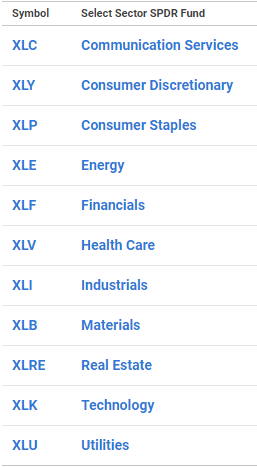


Source: https://www.sectorspdr.com/sectorspdr/sectors

In [16]:
#Define inputs
etf_ids = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
start_date = '2005-12-30'
end_date = '2018-12-31'

dropped_etf =[]
etf_pricing = {}
for etf in tqdm(etf_ids):
    try:
        etf_pricing[etf] = pdr.data.get_data_yahoo(etf, start_date, end_date)
    except:
        dropped_etf.append(etf)
        
#join data & swap index levels
etf_prices = pd.concat(etf_pricing)

etf_prices = etf_prices.swaplevel(0)  #swap levels
etf_prices.sort_index(level=0, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


In [ ]:
#write to csv
etf_prices.to_csv('data//etf_prices.csv')

***

<a id='step0'></a>
## Import Data:
    
   - Asset Prices
   - ETF Prices
   - Fama & French Factors

In [2]:
#Import historical asset prices
input_df = pd.read_csv('data//input_data.csv')

#Change dates to datetime
input_df['Date'] = pd.to_datetime(input_df['Date'])

#Rename columns
input_df.columns = ['date', 
                    'ticker', 
                    'high', 
                    'low', 
                    'open', 
                    'close', 
                    'volume', 
                    'adj_close']

input_df.set_index(['date', 'ticker'], inplace=True)

#change ticker index to string
input_df.set_index([input_df.index.get_level_values(0), 
                    input_df.index.get_level_values(1).astype(str)], 
                   inplace=True)

Merge earlier DataFrame (secs) with input_df to capture market values for groups

In [11]:
secs_df.index.names = ['date', 'ticker']

#change ticker index to string
secs_df.set_index([secs_df.index.get_level_values(0), 
                   secs_df.index.get_level_values(1).astype(str)], 
                  inplace=True)

prices_df = pd.merge(secs_df[['mval']],
                     input_df, 
                     how='left', 
                     left_index=True, 
                     right_index=True)

#Exclude companies with a closing price less than $5 per share
prices_df = prices_df[prices_df['adj_close'] > 5.0]

#Use adjusted close values to compute daily returns
prices_df['daily_ret'] = prices_df.pivot_table(values='adj_close',
                                               index='date', 
                                               columns='ticker').pct_change(periods=1).stack()

Create market cap bins to divide securities into large-cap, mid-cap, and small-cap

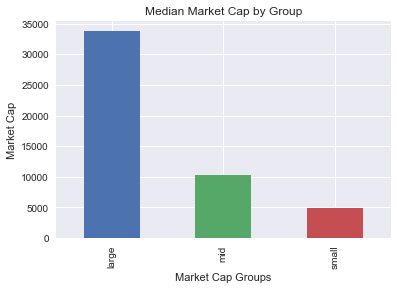

In [12]:
prices_df['mval_rank'] = prices_df.groupby(level=0)['mval'].rank(ascending=False)

prices_df['mcap_groups'] = prices_df['mval_rank'].groupby(level=0)\
    .apply(lambda x: pd.qcut(x=x, q=3, labels=['large', 'mid', 'small']))

#Display median market cap by group
prices_df.groupby('mcap_groups')['mval'].median().plot(kind='bar', 
                                                     title='Median Market Cap by Group')
plt.ylabel('Market Cap')
plt.xlabel('Market Cap Groups')
plt.show()

## Import ETF Prices

Constructing ETF return streams will allow us to approximate each companies co-movement with each sector. This is a common technique that gets applied when the underlying classification schemes are unavailable.

In [3]:
#Import historical ETF prices
etf_prices = pd.read_csv('data//etf_prices.csv', 
                         index_col=['Date', 'Unnamed: 1'])

etf_prices.index.names = ['date', 'symbol']

etf_prices.columns = ['high', 
                      'low', 
                      'open', 
                      'close', 
                      'volume', 
                      'adj_close']

#compute daily returns for ETF's
etf_prices['daily_ret'] = etf_prices['adj_close'].unstack().pct_change(periods=1).stack()

etf_prices.head()

high        low       open      close      volume  \
date       symbol                                                           
2005-12-30 XLB     30.420000  30.250000  30.420000  30.280001    718200.0   
           XLE     50.700001  49.639999  49.799999  50.310001  12112800.0   
           XLF     25.832657  25.653940  25.727051  25.727051   6315300.0   
           XLI     31.520000  31.389999  31.400000  31.420000    806400.0   
           XLK     20.990000  20.870001  20.990000  20.900000   1029900.0   

                   adj_close  daily_ret  
date       symbol                        
2005-12-30 XLB     22.524197        NaN  
           XLE     38.575603        NaN  
           XLF     14.961567        NaN  
           XLI     24.027067        NaN  
           XLK     17.223452        NaN

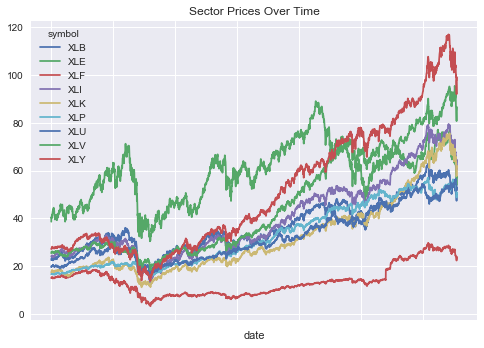

In [88]:
etf_prices['adj_close'].unstack(level=1).plot(title='Sector Prices Over Time');

## Import Fama & French Factor Returns

Below is a description of the 5 factor Fama & French model that was used to approximate exposure to fundamental attributes. High (low) coefficients (beta) to these factors represent a similarity (dissimilarity) to that attribute. For example, a stock with a high beta to SMB behaves more like a small cap company than a large cap company.

- MKT-RF: Return of the market net of the risk-free rate.
- SMB: Return spread of small minus large cap stocks (size effect).
- HML: Return spread of cheap minus expensive stocks(value effect).
- RMW: Return spread of the most profitable firms minus the least profitable (Robust minus weak). 
- CMA: Return spread of firms that invest conservatively vs. aggressively (conservative minus aggressive).

**Resources:**

- [Fama & French 5 Factor Model](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5developed.html)

- [Quantsportal - Fama & French five factor asset pricing model](http://www.quantsportal.com/fama-french-five-factor-asset-pricing-model/)

In [4]:
ff_rets = pd.read_csv('data//famafrenchformatted.csv')

ff_rets.columns = ['date', 
                   'mkt-rf', 
                   'smb', 
                   'hml', 
                   'rmw', 
                   'cma', 
                   'rf']

#format dates as datetime
ff_rets['date'] = pd.to_datetime(ff_rets['date'].astype(str))

#set dates to index
ff_rets.set_index('date', inplace=True)

#preview data
ff_rets.head()

mkt-rf   smb   hml   rmw   cma    rf
date                                            
2005-12-30   -0.42 -0.02  0.29  0.03  0.12  0.01
2006-01-02   -0.03 -0.01 -0.01  0.00  0.00  0.02
2006-01-03    1.59 -0.24  0.16  0.17 -0.26  0.02
2006-01-04    0.52  0.36 -0.14 -0.19  0.09  0.02
2006-01-05   -0.08  0.09 -0.21 -0.50  0.14  0.02

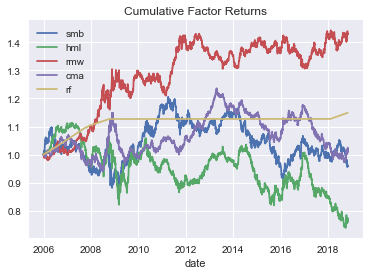

In [5]:
#Display cumulative factor returns
(ff_rets[['smb', 'hml', 'rmw', 'cma', 'rf']]/100+1).cumprod().plot(title='Cumulative Factor Returns');

***
<a id='featureengineering'></a>
# Feature Engineering

***

**IMPORTANT NOTE:** This section is fairly computationally expensive, and as a result may take a while to run. You can skip forward to the Exploratory Data Analysis section. The information from this segment of the notebook has been written to a file and loaded in that section. The link below can be used to jump forward.

### [Skip Forward to Exploratory Data Analysis](#step1)
***


We will rely on our domain knowledge to engineer a diverse set of features using the OHLCV obtained earlier. OHLCV information is a great resource for conducting empirical research in the public domain. As we've seen up to this point, it's farily easy to acquire (though there are plenty of caveats which go beyond the scope of this assignment) and it lends itself to computing a rich feature space.

The features we will compute from here on out can be broadly categorized into one of two categories:

    1) Time-Series Exposures
    2) Technical Indicators

Time-series exposures are commonly used to approximate an assets' behavior with respect to another attribute when information on that attribute is unavailable. For example, we do not have access to an industry standard taxonomy, like [GICS](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard), but that doesn't mean we can't include that information in our study. Instead, we will approximate our assets' exposure to those groups by computing a coefficient based off of the underlying return streams of the assets and the groups. Assets with larger group coefficients experience similarities with respect to the behavior of their prices. A similar approach will be used to approximate style exposures too. This will help identify which assets behave like small or large cap, value or growth, etc.

Below are the features that will be computed throughout this section.

    • Time-Series Exposures:
        o Sectors:
            ▪ Beta to Communication Services (XLC)
            ▪ Beta to Consumer Discretionary (XLY)
            ▪ Beta to Consumer Staples (XLP)
            ▪ Beta to Energy (XLE)
            ▪ Beta to Financials (XLF)
            ▪ Beta to Health Care (XLV)
            ▪ Beta to Industrials (XLI)
            ▪ Beta to Materials (XLB)
            ▪ Beta to Technology (XLK)
            ▪ Beta to Utilities (XLU)
        o Styles:
            ▪ Beta to Fama & French SMB (Small Minus Big) portfolios
            ▪ Beta to Fama & French HML (High Minus Low) portfolios
            ▪ Beta to Fama & French MKT-RF (Market Net of Risk-Free Rate) portfolios
            ▪ Beta to Fama & French RMW (Robust Minus Weak) portfolios
            ▪ Beta to Fama & French CMA (Conservative Minus Aggressive) portfolios
    
    • Technical Factors:
        o Relative Strength Index (RSI)
        o Moving Average Signal Convergence Divergence (MACD)
        o Long-Term Momentum: Price change over several horizons
        o Short-Term Reversal: Price change over several near-term horizons
        o Percent above and below the 52-week high and low price
        o Percent above and below the 30 and 200 days moving average price
        o Volatility: Standard deviation of returns over several horizons
        o Money Flow Index
        o Directional Movement Index (DX)
        o Stochastic Oscillator
        o Average True Range (ATR)
         
Now let's estimate our time-series exposures to sectors and the Fama & French style factors. Before computing those exposures, we are first going to analyze our return streams to identify and treat outliers. It's important to clean our data prior to engineering our features to help mitigate the amount of noise being incorporated into our feature space. 

### Evaluate Return Streams

As expected, the majority of outliers are present at the asset level

In [14]:
#Describe asset returns
print('Asset Returns: \n')
print(prices_df['daily_ret'].describe().round(2))

#Describe ETF returns
print('\nETF Returns: \n')
print(etf_prices['daily_ret'].describe().round(2))

#Describe Fama & French returns
print('\nFama & French Returns: \n')
print(ff_rets.describe().round(2))

Asset Returns: 

count    1847723.00
mean           0.19
std           81.05
min           -1.00
25%           -0.01
50%            0.00
75%            0.01
max        83063.52
Name: daily_ret, dtype: float64

ETF Returns: 

count    29439.00
mean         0.00
std          0.01
min         -0.17
25%         -0.01
50%          0.00
75%          0.01
max          0.31
Name: daily_ret, dtype: float64

Fama & French Returns: 

        mkt-rf      smb      hml      rmw      cma       rf
count  3349.00  3349.00  3349.00  3349.00  3349.00  3349.00
mean      0.03    -0.00    -0.01     0.01     0.00     0.00
std       1.18     0.48     0.52     0.35     0.33     0.01
min      -8.97    -3.74    -2.76    -2.48    -1.69     0.00
25%      -0.38    -0.28    -0.27    -0.16    -0.18     0.00
50%       0.05     0.00    -0.01     0.01    -0.01     0.00
75%       0.53     0.27     0.22     0.20     0.17     0.01
max      10.64     3.83     3.44     1.83     1.90     0.02


The histogram and box & whiskers plots below illustrate how noisy our asset returns are. The box & whisker plot is particularly interesting as it displays that most of the outliers are present in the mid & small cap cohorts of our analysis. This makes sense based on the number of publications that have documented the inverse correlation between company size and volatility.

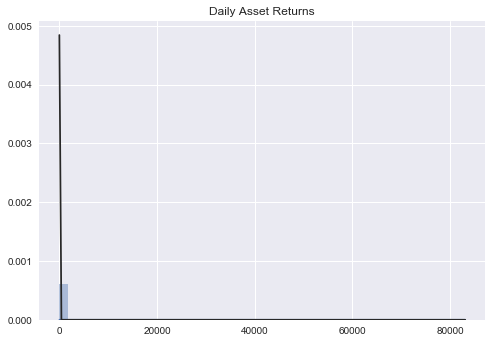

In [92]:
from scipy.stats import norm

sns.distplot(prices_df[['daily_ret']].dropna(), 
             bins=50, fit=norm)
plt.title('Daily Asset Returns')
plt.show()

There are massive outliers present in our smallest cap securities. 
This isn't too surprising, but we will want to limit the affect they
Have on our analysis

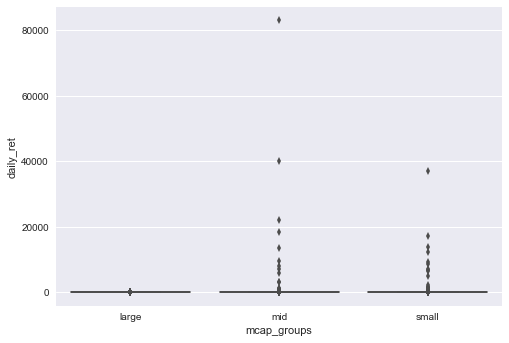

In [93]:
sns.boxplot(y='daily_ret', x='mcap_groups', data=prices_df, orient='v');

## Treating Outliers

In this section we will explore two methods for treating outliers. In the first method we will set bounds based on each assets' z-score, and in the other we will use percentile limits. Ultimately, the more robust of the two will be selected to treat our dataset. 

### Method 1: Z-Score

Apply z-scores to the daily returns and exclude companies with values that are > +/- 3 standard deviations from the mean.

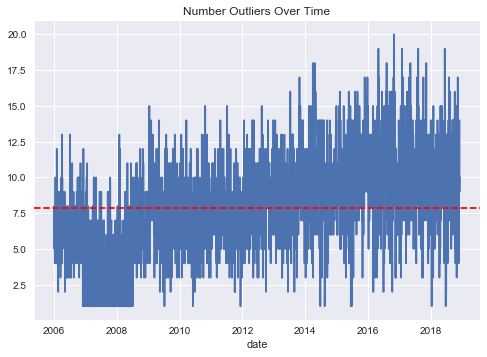

In [94]:
from scipy import stats

#Apply a z-score to standardize each assets' return
prices_df['daily_ret_z'] = prices_df['daily_ret'].groupby(level=0).transform(lambda x: stats.zscore(x))

#Plot the number of securities with daily returns greater than 3 std from the mean
num_outliers = prices_df[prices_df['daily_ret_z'].abs() > 3.]['daily_ret']\
.groupby(level=0).count()
num_outliers.plot(title='Number Outliers Over Time')
plt.axhline(num_outliers.mean(), linestyle='--', color='red')
plt.show()

This is an effective method however it seems there are more outliers present in the small cap group than I would like.  

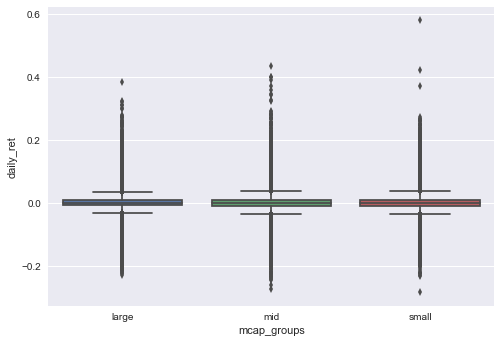

In [95]:
sns.boxplot(y='daily_ret', 
            x='mcap_groups', 
            data=prices_df[prices_df['daily_ret_z'].abs() < 3.], 
            orient='v');

### Method 2: Percentile Bounds

Create a series of cutoffs that represent the upper and lower bounds of returns that we'd like to use going forward.

In [100]:
upper_bound = .999 
lower_bound = .001
return_cutoffs = prices_df['daily_ret'].quantile([lower_bound, 
                                                  upper_bound]).values
print("Upper Bound: {:.3f}".format(return_cutoffs[1]))
print("Lower Bound: {:.3f}".format(return_cutoffs[0]))

Upper Bound: 0.157
Lower Bound: -0.136


In this scenario, using percentile bounds vs. z-score limits proves to be a more robust way to treat our dataset, so we'll stick with that approach when estimating our time-series exposures.

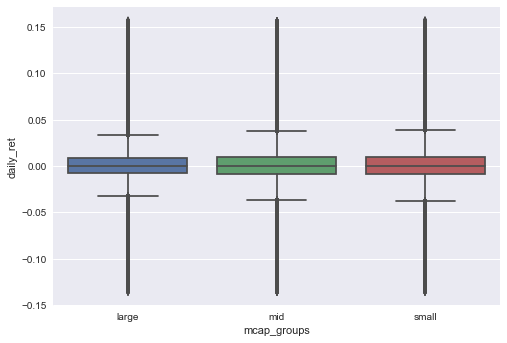

In [101]:
#Define the percentile filter based on the cutoffs
ret_filter = prices_df['daily_ret'].between(return_cutoffs[0],
                                            return_cutoffs[1], 
                                            inclusive=True)

sns.boxplot(y='daily_ret', x='mcap_groups',
            data=prices_df[ret_filter], 
            orient='v');

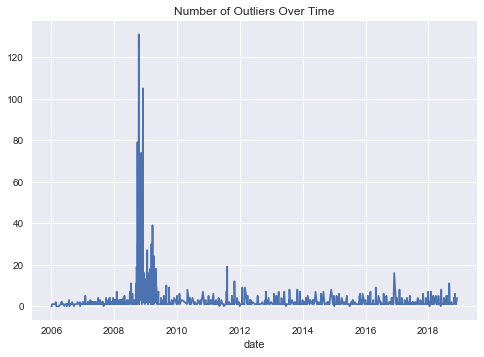

In [102]:
#Display the number of assets beyond the cutoffs
prices_df[ret_filter == False].groupby(level=0)['daily_ret'].count().plot()
plt.title('Number of Outliers Over Time')
plt.show()

Clip returns at the upper and lower bound then visualize the new distribution of daily returns. 

In [104]:
prices_df['daily_ret'].clip_upper(return_cutoffs[1], axis=0, inplace=True)
prices_df['daily_ret'].clip_lower(return_cutoffs[0], axis=0, inplace=True)

As you can see below, we've created a robust set of daily returns. We have taken the upper limit down from over 80,000% (!) to 60% with the z-score method and finally to +/- 15%. Our time-series exposures will benefit enormously by reducing the amount of noise in our return streams.

I read a number of articles and found this one particularly helpful (and simple!) when thinking through outlier methods to choose between: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

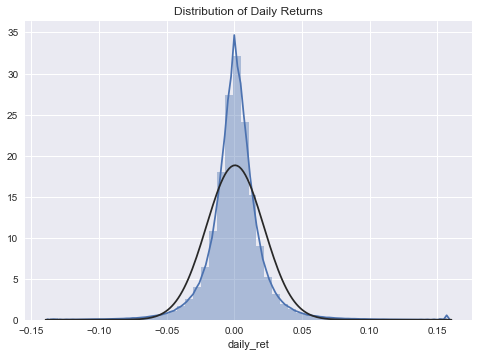

In [105]:
sns.distplot(prices_df['daily_ret'].dropna(), bins=50, fit=norm)
plt.title('Distribution of Daily Returns')
plt.show()

***

## Sectors Exposures

Now that we have a clean set of daily asset returns, we can create exposures for sectors and style factors. Let's start with the sectors shown below:

    o Sectors:
        ▪ Beta to Communication Services (XLC)
        ▪ Beta to Consumer Discretionary (XLY)
        ▪ Beta to Consumer Staples (XLP)
        ▪ Beta to Energy (XLE)
        ▪ Beta to Financials (XLF)
        ▪ Beta to Health Care (XLV)
        ▪ Beta to Industrials (XLI)
        ▪ Beta to Materials (XLB)
        ▪ Beta to Technology (XLK)
        ▪ Beta to Utilities (XLU)    

In [107]:
etf_ids = ['XLY', 
           'XLP', 
           'XLE', 
           'XLF', 
           'XLV', 
           'XLI', 
           'XLB', 
           'XLK', 
           'XLU']

sector_betas_dict = {}
for etf in etf_ids:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252, 
                                                          min_periods=(int(252*.8))).cov(etf_prices['daily_ret'].unstack()[etf])
    
    var = etf_prices['daily_ret'].unstack()[etf].rolling(252, 
                                                         min_periods=(int(252*.8))).var()
    
    sector_betas_dict[etf] = cov.apply(lambda x: x / var)

sector_betas = pd.DataFrame({k:v.stack() for k, v in sector_betas_dict.items()})

### Fama & French Exposures

Next, we'll compute a series of exposures for our Fama & French factors. Before doing that, we need to align the calendars between the two datasets. As of now, the Fama & French data is based on North American securities, so it's using a combination of US & Canadian trading days vs. US only.

In [113]:
us_dates = prices_df.index.get_level_values(0).unique()
ff_rets = ff_rets[ff_rets.index.isin(us_dates)]

The routine below is similar to what was done when computing sector exposures. Each securities covariance to the style attributes in the Fama & French dataset is calculated over a rolling one year (252 day) period.

In [114]:
ff_betas_dict = {}
for factor in ff_rets.columns:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252, 
                                                          min_periods=(int(252*.8))).cov(ff_rets[factor]/100)
    
    var = (ff_rets[factor]/100).rolling(252, min_periods=(int(252*.8))).var()
    
    ff_betas_dict[factor] = cov.apply(lambda x: x / var)

ff_betas = pd.DataFrame({k:v.stack() for k, v in ff_betas_dict.items()})
ff_betas.drop('rf', axis=1, inplace=True)

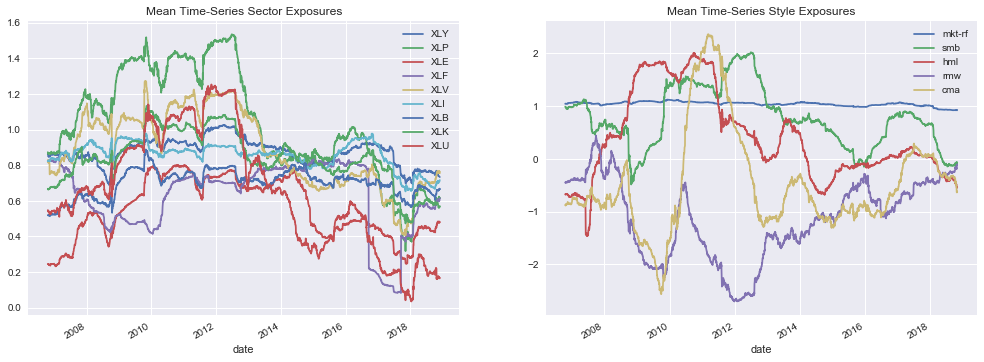

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(17, 6))

sector_betas.groupby(level=0).mean().plot(title='Mean Time-Series Sector Exposures', ax=ax1)

ff_betas.groupby(level=0).mean().plot(title='Mean Time-Series Style Exposures', ax=ax2);


### Technical Factors

    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • Long-Term Momentum: Price change over several horizons
    • Short-Term Reversal: Price change over several near-term horizons
    • Percent above and below the 52-week high and low price
    • Percent above and below the 30 and 200 days moving average price
    • Volatility: Standard deviation of returns over several horizons
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)

Below we'll use `pandas` to begin this process.

- % Above/Below Moving Average Price - 30 day, 50 day, and 200 day
- % Above/Below 52 week high and low price
- Binary flags for if current price > 30d_mavg; 30d_mavg > 50d_mavg; 50d_mavg > 200d_mavg

In [68]:
#Unstack data to create a time-series view
adj_close = prices_df.pivot_table(values=['adj_close'],
                                  index='date', 
                                  columns='ticker').fillna(method='ffill')

fast_period = 30
med_period = 50
slow_period = 200
factor_data = {}
for period in [fast_period, med_period, slow_period]:
    """
    All moving averages require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_mavg'] = adj_close['adj_close'].rolling(period, 
                                                                  min_periods=(int(period*.8))).mean().stack()
    
factor_data = pd.DataFrame(factor_data)

In [69]:
factor_data = pd.merge(factor_data, 
                       prices_df[['adj_close', 'mcap_groups']],
                       how='outer', 
                       right_index=True, 
                       left_index=True)

Binary Moving Average Indicators

In [70]:
#Price > 30D Moving Average Price
factor_data['p_gt_30d'] = np.where(factor_data['adj_close'] > factor_data['30d_mavg'], 1, 0)

#Price > 50D Moving Average Price
factor_data['p_gt_50d'] = np.where(factor_data['adj_close'] > factor_data['50d_mavg'], 1, 0)

#Price > 200D Moving Average Price
factor_data['p_gt_200d'] = np.where(factor_data['adj_close'] > factor_data['200d_mavg'], 1, 0)

#30D Moving Average Price > 50D Moving Average Price
factor_data['30d_gt_50d'] = np.where(factor_data['30d_mavg'] > factor_data['50d_mavg'], 1, 0)

#50D Moving Average Price > 200D Moving Average Price
factor_data['50d_gt_200d'] = np.where(factor_data['50d_mavg'] > factor_data['200d_mavg'], 1, 0)

Percent Change from Moving Averages

In [71]:
#Percent above 30d moving average
factor_data['perc_above30d'] = (factor_data['adj_close'] / factor_data['30d_mavg'] - 1) * 100

#Percent above 50d moving average
factor_data['perc_above50d'] = (factor_data['adj_close'] / factor_data['50d_mavg'] - 1) * 100

#Percent above 200d moving average
factor_data['perc_above200d'] = (factor_data['adj_close'] / factor_data['200d_mavg'] - 1) * 100

Calculate Percent Above and Below the 52 Week High & Low

In [72]:
#1yr high & low prices
factor_data['oneyr_high'] = adj_close['adj_close'].rolling(252, 
                                                           min_periods=int(252*.8)).max().stack()

factor_data['oneyr_low'] = adj_close['adj_close'].rolling(252, 
                                                          min_periods=int(252*.8)).min().stack()

In [73]:
#Percent above 52 week high
factor_data['perc_above52wh'] = (factor_data['adj_close'] / factor_data['oneyr_high'] - 1) * 100

#Percent above 52 week low
factor_data['perc_above52wl'] = (factor_data['adj_close'] / factor_data['oneyr_low'] - 1) * 100

Define long-term & short-term momentum:

- Long-term Momentum: 12M - 1M Price Change
- Medium-term Momentum: 6M - 1M Price Change
- Short-term Momentum: Price change over most recent month

In [74]:
#Long-term momentum - 12 - 1M price momentum
factor_data['lt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(252) - 1).stack()

#Medium-term momentum - 6 - 1M price momentum
factor_data['mt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(126) - 1).stack()

#Short-term momentum
factor_data['st_momentum'] = adj_close.apply(lambda x: x / x.shift(21) - 1).stack()

Define stock price volatility over 1, 3, 6, and 12 months

In [75]:
#Query daily returns
daily_rets = prices_df.pivot_table(values=['daily_ret'],
                                   index='date', 
                                   columns='ticker')

#Define horizons for volatility factors
vol_horizons = [x*21 for x in [1, 3, 6, 12]]

for period in vol_horizons:
    """
    All volatilities require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_vol'] = (daily_rets['daily_ret'].rolling(period, 
                                                                  min_periods=(int(period*.8)))\
                                      .std() * np.sqrt(252)).stack()

Construct technical factors using `talib`
    
    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • On Balance Volume (OBV)
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)      

In [82]:
import talib as ta

pricing_pivot = prices_df.pivot_table(values=['high', 'low', 'open', 'close', 'volume', 'adj_close'],
                                      index='date', 
                                      columns='ticker').fillna(method='ffill')

In [95]:
#RSI
factor_data['RSI'] = adj_close.apply(lambda x: ta.RSI(x, timeperiod=14)).stack()

#MACD
for i, signal in enumerate(['macd', 'macdsignal', 'macdhist']):
    factor_data[signal] = adj_close['adj_close']\
    .apply(lambda x: ta.MACD(x, 
                             fastperiod=12, 
                             slowperiod=26, 
                             signalperiod=9)[i]).stack()

#BOP, MFI, DX, STOCH_OSC, ATR
bop = {}
mfi = {}
dx = {}
stoch_osc = {}
ATR = {}
for i, sec in enumerate(pricing_pivot['adj_close'].columns.tolist()):
    open_p = pricing_pivot['open'].iloc[:, i]
    high = pricing_pivot['high'].iloc[:, i]
    low = pricing_pivot['low'].iloc[:, i]
    close = pricing_pivot['close'].iloc[:, i]
    volume = pricing_pivot['volume'].iloc[:, i]
    
    try:        
        bop[sec] = ta.BOP(open_p, high, low, close)
        mfi[sec] = ta.MFI(high, low, close, volume, timeperiod=14)
        dx[sec] = ta.DX(high, low, close, timeperiod=14)
        stoch_osc[sec] = ta.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        ATR[sec] = ta.ATR(high, low, close, timeperiod=14)      
        
    except:
        pass

Combine dictionaries for technical factors

In [99]:
tech_factor_dictionaries = [bop, mfi, dx, stoch_osc, ATR]
tech_factor_names = ['bop', 'mfi', 'dx', 'stoch_osc', 'atr']
tech = []
for factor, col in zip(tech_factor_dictionaries, tech_factor_names):
    df = pd.DataFrame(pd.concat(factor), columns=[col])
    df = df.swaplevel()
    df.sort_index(level=0, inplace=True)
    tech.append(df)
    
tech_factors = pd.concat(tech, axis=1)
tech_factors.index.names = ['date', 'ticker']

Join all factors together and write to csv. That file will be used for the remainder of the analysis.

In [105]:
all_factors = pd.merge(factor_data, 
                       tech_factors, 
                       how='outer', 
                       right_index=True,
                       left_index=True)

betas = pd.merge(ff_betas, 
                 sector_betas, 
                 how='outer',
                 right_index=True, 
                 left_index=True)

all_factors = pd.merge(all_factors, 
                       betas, 
                       how='outer',
                       right_index=True, 
                       left_index=True)

Write final factor data to csv

In [106]:
all_factors.to_csv('data//all_factors.csv')

***
<a id='eda'></a>
# Exploratory Data Analysis on Features

All of the features in this analysis will be explored further in this section of the notebook. Throughout this section we will:

- Explore relationships
- Identify common start & end dates for our analysis
- Create our target variable
- Identify and treat outliers
- Adjust feature distributions where necessary 

In [26]:
all_factors = pd.read_csv('data//all_factors.csv', 
                          index_col=['date', 'ticker'])

all_factors = all_factors[~all_factors['adj_close'].isnull()]

ff_factors = ['mkt-rf', 
              'smb', 
              'hml', 
              'rmw', 
              'cma']

sector_betas = ['XLY', 
                'XLP', 
                'XLE', 
                'XLF', 
                'XLV', 
                'XLI', 
                'XLB', 
                'XLK', 
                'XLU']

technical_factors = ['RSI', 
                     'macd', 
                     'macdsignal', 
                     'macdhist', 
                     'bop', 
                     'mfi', 
                     'dx', 
                     'stoch_osc', 
                     'atr']
                     
momentum_vol = ['lt_momentum', 
                'mt_momentum', 
                'st_momentum',
                '21d_vol', 
                '63d_vol', 
                '126d_vol', 
                '252d_vol'] 
                     

pricing_factors = ['perc_above30d', 
                   'perc_above50d',
                   'perc_above200d', 
                   'perc_above52wh',
                   'perc_above52wl']

In [7]:
all_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1848813 entries, (2005-12-30, A) to (2018-11-30, ZTS)
Data columns (total 47 columns):
30d_mavg          float64
50d_mavg          float64
200d_mavg         float64
adj_close         float64
mcap_groups       object
p_gt_30d          float64
p_gt_50d          float64
p_gt_200d         float64
30d_gt_50d        float64
50d_gt_200d       float64
perc_above30d     float64
perc_above50d     float64
perc_above200d    float64
oneyr_high        float64
oneyr_low         float64
perc_above52wh    float64
perc_above52wl    float64
lt_momentum       float64
mt_momentum       float64
st_momentum       float64
21d_vol           float64
63d_vol           float64
126d_vol          float64
252d_vol          float64
RSI               float64
macd              float64
macdsignal        float64
macdhist          float64
bop               float64
mfi               float64
dx                float64
stoch_osc         float64
atr               float64
mkt-rf

In [5]:
all_factors.describe().round(2)

30d_mavg    50d_mavg   200d_mavg   adj_close    p_gt_30d    p_gt_50d  \
count  1824303.00  1809482.00  1705022.00  1848813.00  1848813.00  1848813.00   
mean       353.36      353.51      352.06      353.25        0.58        0.59   
std       7372.67     7360.73     7273.52     7494.60        0.49        0.49   
min          5.00        5.00        5.01        5.00        0.00        0.00   
25%         24.21       24.21       24.10       24.19        0.00        0.00   
50%         39.83       39.79       39.39       39.86        1.00        1.00   
75%         66.76       66.59       65.21       66.98        1.00        1.00   
max     323866.90   319905.38   305362.96   964377.94        1.00        1.00   

        p_gt_200d  30d_gt_50d  50d_gt_200d  perc_above30d     ...      \
count  1848813.00  1848813.00   1848813.00     1824303.00     ...       
mean         0.62        0.59         0.63           0.67     ...       
std          0.48        0.49         0.48           7.35     ...       
min          0.00        0.00         0.00         -99.99     ...       
25%          0.00        0.00         0.00          -2.25     ...       
50%          1.00        1.00         1.00           0.92     ...       
75%          1.00        1.00         1.00           3.79     ...       
max          1.00        1.00         1.00        1889.64     ...       

              cma         XLY         XLP         XLE         XLF         XLV  \
count  1553381.00  1566123.00  1566123.00  1566123.00  1566123.00  1566123.00   
mean        -0.44        0.87        1.01        0.55        0.62        0.87   
std          1.40        0.33        0.45        0.32        0.32        0.37   
min         -9.69       -0.95       -0.84       -0.42       -0.77       -0.48   
25%         -1.10        0.65        0.72        0.32        0.39        0.62   
50%         -0.40        0.86        0.94        0.50        0.62        0.82   
75%          0.21        1.08        1.24        0.73        0.84        1.09   
max          5.78        3.03        3.35        2.44        2.45        2.95   

              XLI         XLB         XLK         XLU  
count  1566123.00  1566123.00  1566123.00  1566123.00  
mean         0.85        0.70        0.83        0.63  
std          0.33        0.30        0.35        0.43  
min         -0.60       -0.43       -0.73       -1.03  
25%          0.63        0.49        0.58        0.33  
50%          0.84        0.68        0.80        0.58  
75%          1.07        0.88        1.05        0.91  
max          2.52        2.77        3.36        2.67  

[8 rows x 46 columns]

### Create target variable (1D, 5D, 21D, 42D, 63D forward return horizons)

The 63 day future return horizon will be used for this analysis.

In [27]:
fwd_ret_horizons = [1, 5, 21, 42, 63]
for ret in fwd_ret_horizons:
    all_factors['fwdret_' + str(ret) + 'd'] = all_factors.pivot_table(values='adj_close',
                                                                      index='date', 
                                                                      columns='ticker').pct_change(ret).shift(-ret).stack()

### Binarize forward return horizons

In [28]:
all_factors[['fwdret_1d_target',
             'fwdret_5d_target', 
             'fwdret_21d_target', 
             'fwdret_42d_target', 
             'fwdret_63d_target']] = all_factors[['fwdret_1d',
                                                  'fwdret_5d', 
                                                  'fwdret_21d', 
                                                  'fwdret_42d', 
                                                  'fwdret_63d']].groupby(level=0)\
.transform(lambda x: np.where(x > x.median(), 1, 0))

### Check start and end dates for factors by category:

In [7]:
def StartAndEndDates(factor_list):
    for factor in factor_list:
        mask = all_factors[factor].notnull()
        start_date = all_factors.loc[mask, [factor]].index.get_level_values(0).unique()[0]
        end_date = all_factors.loc[mask, [factor]].index.get_level_values(0).unique()[-1]
        print("    {}: Begins on - {} & Ends on - {}".format(factor, start_date, end_date))

print("Start & End dates for Sector Exposures: \n")
StartAndEndDates(sector_betas)

print("\n Start & End dates for Fama French Exposures: \n")
StartAndEndDates(ff_factors)

print("\n Start & End dates for Technical Exposures: \n")
StartAndEndDates(technical_factors)

print("\n Start & End dates for Pricing Exposures: \n")
StartAndEndDates(pricing_factors)

print("\n Start & End dates for Forward Returns: \n")
StartAndEndDates(['fwdret_' + str(x) + 'd' for x in fwd_ret_horizons])  

Start & End dates for Sector Exposures: 

    XLY: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLP: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLE: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLF: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLV: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLI: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLB: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLK: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLU: Begins on - 2006-10-19 & Ends on - 2018-11-30

 Start & End dates for Fama French Exposures: 

    mkt-rf: Begins on - 2006-10-19 & Ends on - 2018-10-31
    smb: Begins on - 2006-10-19 & Ends on - 2018-10-31
    hml: Begins on - 2006-10-19 & Ends on - 2018-10-31
    rmw: Begins on - 2006-10-19 & Ends on - 2018-10-31
    cma: Begins on - 2006-10-19 & Ends on - 2018-10-31

 Start & End dates for Technical Exposures: 

    RSI: Begins on - 2006-01-23 & Ends on - 2018-11-30
    macd: Begins on - 2006-02-17 &

In [29]:
#Keep a date range of 2007-01-05 to 2018-08-29
all_factors = all_factors.loc['2007-01-05':'2018-08-29']

In [10]:
#Count number of missing fields
total_missing = all_factors.isnull().sum()
percent = (total_missing / len(all_factors)) * 100
pd.DataFrame({'Total': total_missing, 
              'Percent(%)': percent.round(1)}).sort_values('Percent(%)', 
                                                  ascending=False).round(3)

Total  Percent(%)
252d_vol           185820        11.0
mkt-rf             185820        11.0
XLK                186177        11.0
XLB                186177        11.0
XLI                186177        11.0
XLV                186177        11.0
XLF                186177        11.0
XLE                186177        11.0
XLP                186177        11.0
XLY                186177        11.0
cma                185820        11.0
rmw                185820        11.0
hml                185820        11.0
smb                185820        11.0
XLU                186177        11.0
126d_vol           118380         7.0
lt_momentum        105130         6.2
perc_above52wh      85186         5.0
perc_above52wl      85186         5.0
oneyr_high          85186         5.0
oneyr_low           85186         5.0
63d_vol             81717         4.8
200d_mavg           69360         4.1
perc_above200d      69360         4.1
mt_momentum         56213         3.3
21d_vol             30885         1.8
perc_above50d       19755         1.2
50d_mavg            19755         1.2
macd                17100         1.0
macdsignal          17100         1.0
macdhist            17100         1.0
stoch_osc           14899         0.9
perc_above30d       12685         0.8
30d_mavg            12685         0.8
st_momentum         11749         0.7
atr                  7874         0.5
dx                   7874         0.5
mfi                  7874         0.5
RSI                  7874         0.5
fwdret_5d               0         0.0
fwdret_21d              0         0.0
fwdret_42d              0         0.0
fwdret_63d              0         0.0
fwdret_1d_target        0         0.0
fwdret_5d_target        0         0.0
fwdret_21d_target       0         0.0
fwdret_42d_target       0         0.0
bop                     0         0.0
fwdret_1d               0         0.0
50d_gt_200d             0         0.0
30d_gt_50d              0         0.0
p_gt_200d               0         0.0
p_gt_50d                0         0.0
p_gt_30d                0         0.0
mcap_groups             0         0.0
adj_close               0         0.0
fwdret_63d_target       0         0.0

one-hot encode market cap groups

In [30]:
all_factors = pd.merge(all_factors,
                       pd.get_dummies(all_factors['mcap_groups']),
                       how='left',
                       left_index=True,
                       right_index=True                      
                      )

Resample data to understand relationships present in the data

In [31]:
num_samples = 100
random_dates = all_factors.sample(num_samples, random_state=2).index.get_level_values(0).unique()
resampled_df = all_factors[all_factors.index.get_level_values(0).isin(random_dates)]

Analyze distributions within market cap segments. 

Fama French & Sector betas appear to follow a guassian distribution within reason. This makes sense given the outlier handling that was applied prior to constructing those features.

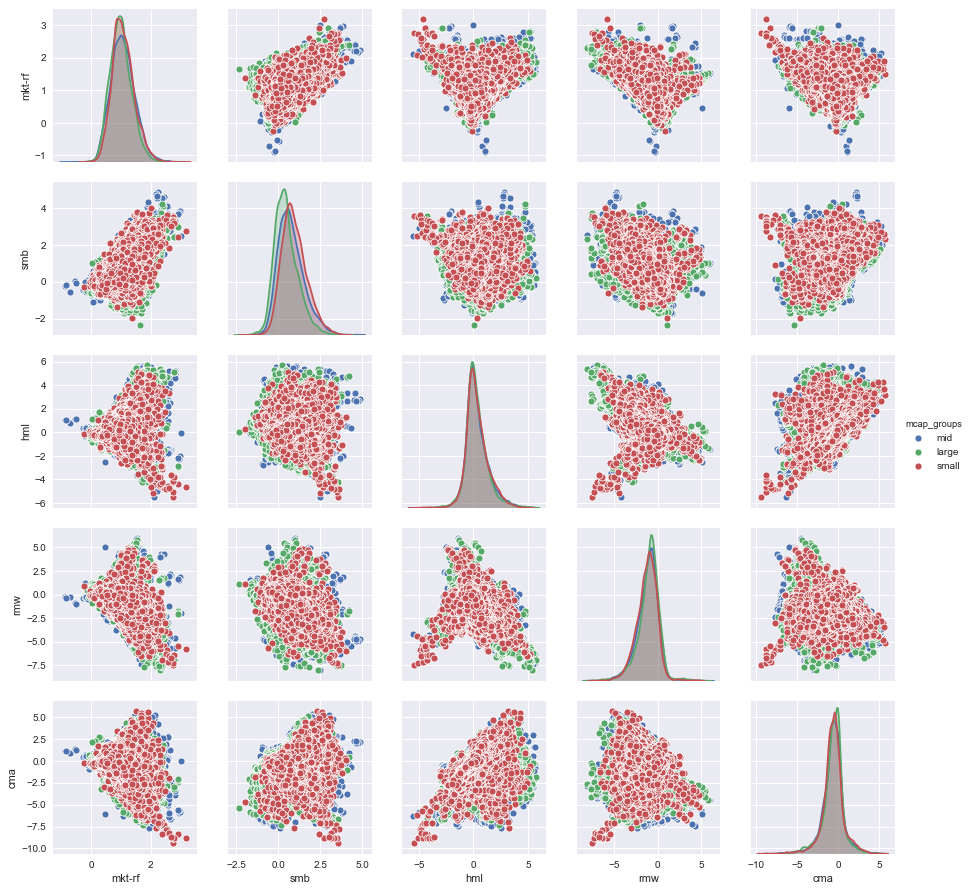

In [32]:
import seaborn as sns
sns.pairplot(resampled_df[ff_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde', 
             hue='mcap_groups');

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


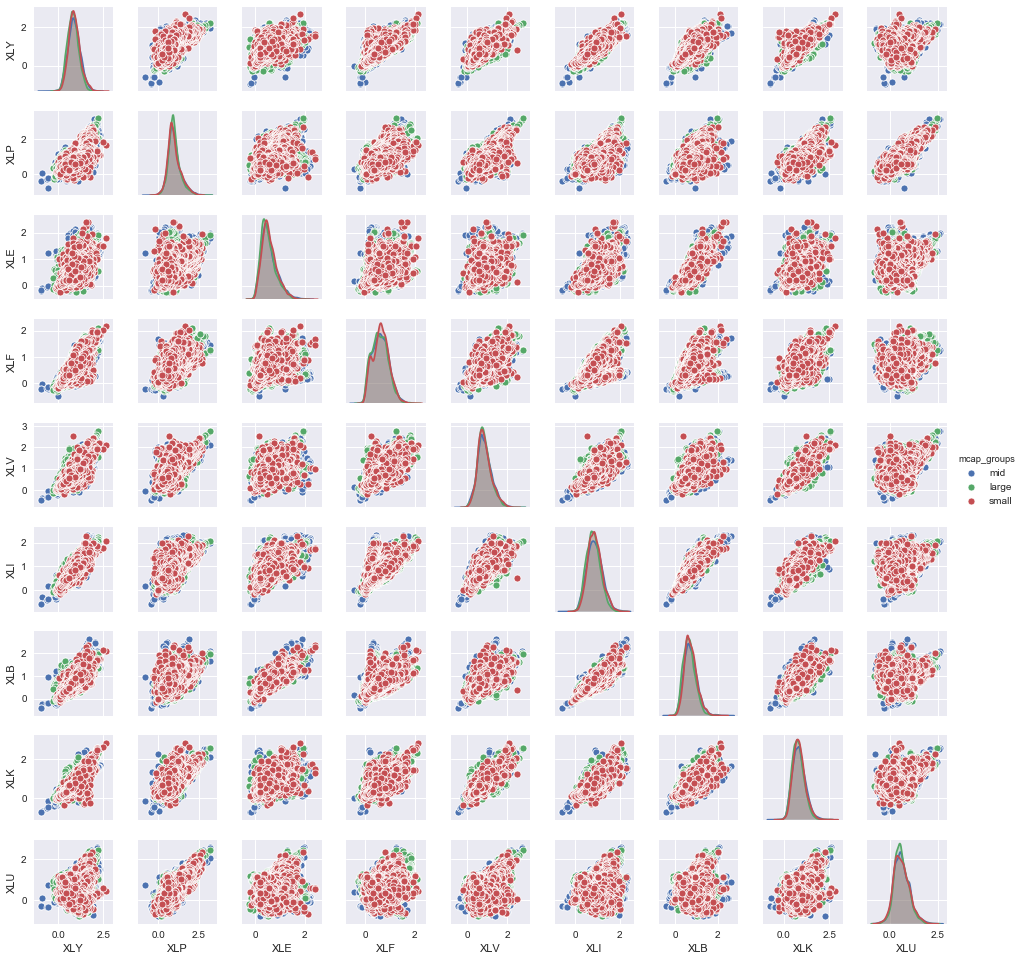

In [10]:
sns.pairplot(resampled_df[sector_betas + ['mcap_groups']].dropna(), 
             diag_kind='kde', 
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


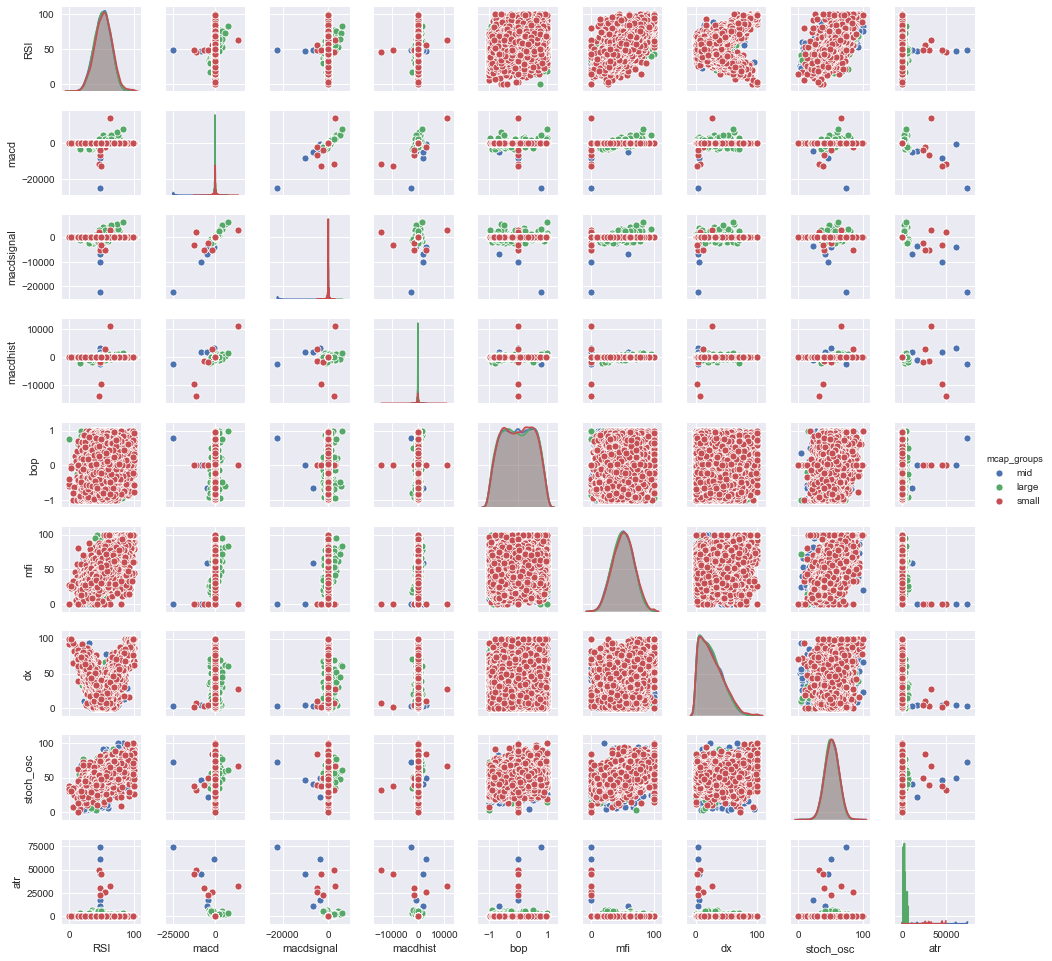

In [11]:
sns.pairplot(resampled_df[technical_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


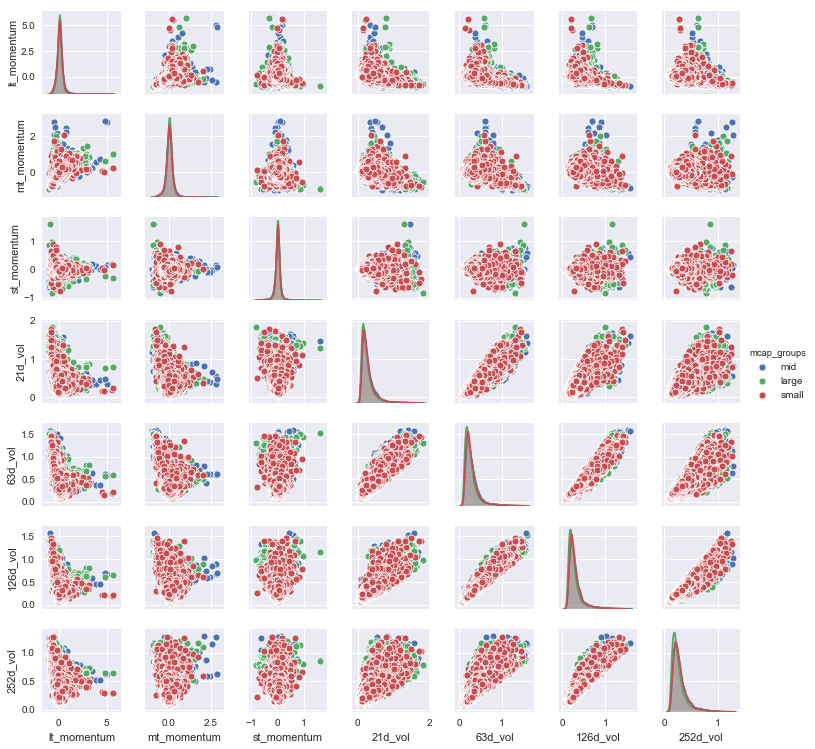

In [12]:
sns.pairplot(resampled_df[momentum_vol + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


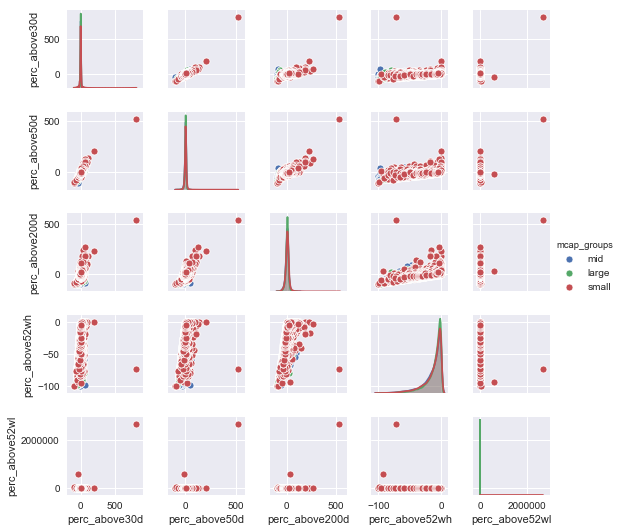

In [13]:
sns.pairplot(resampled_df[pricing_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

In [33]:
features = ff_factors +\
sector_betas +\
technical_factors +\
momentum_vol +\
pricing_factors +\
['large', 'mid', 'small']

**Univariate Plots**

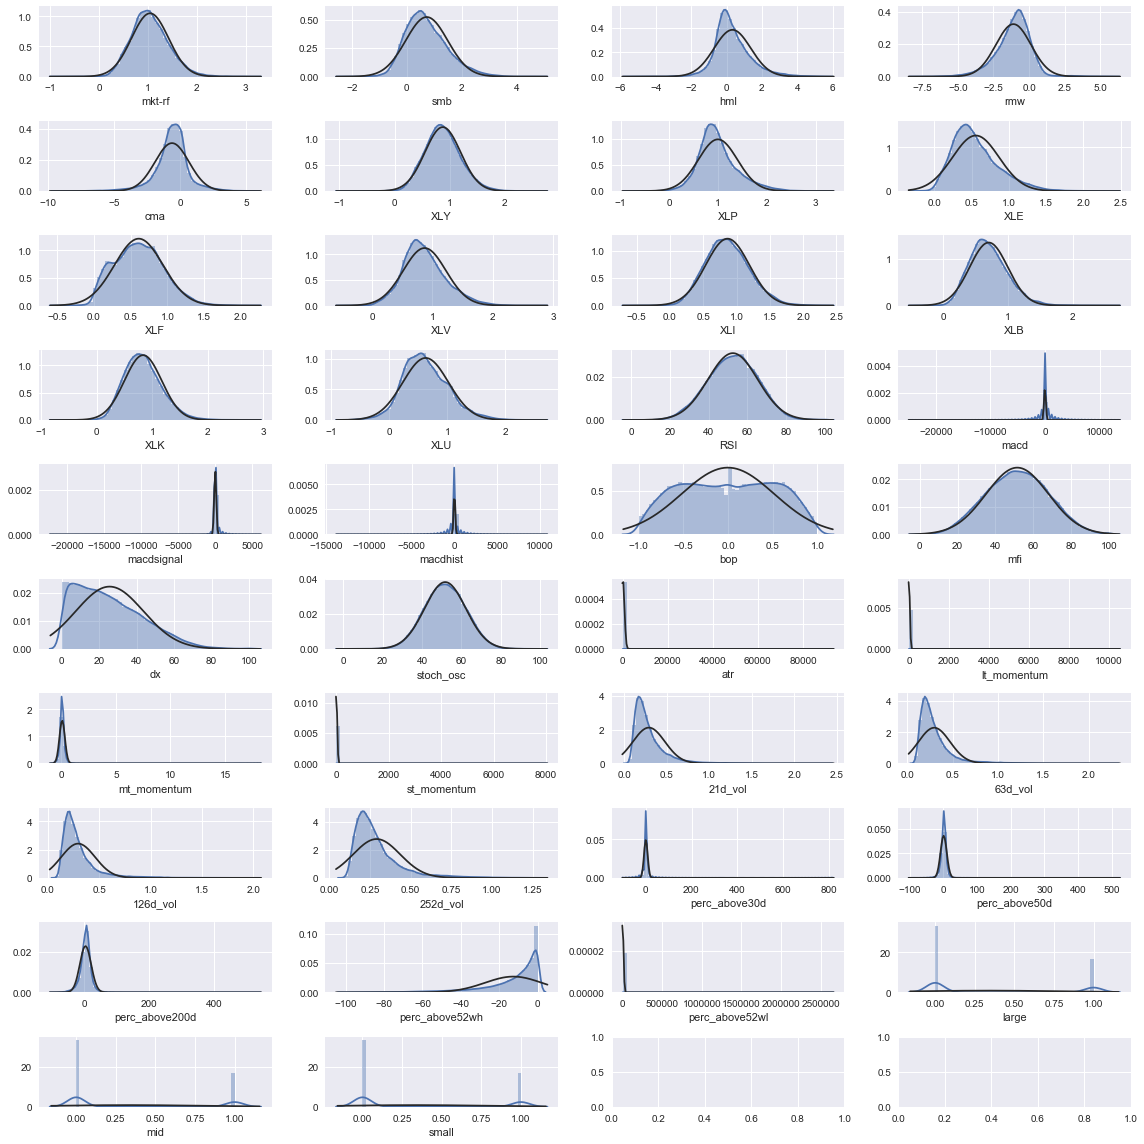

In [34]:
import copy
from scipy.stats import norm
import seaborn as sns

mask = features
ncols = 4
nrows = -(-len(mask)//ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16), sharex=False)
for d, ax in zip(mask, axes.flat):
    sns.distplot(resampled_df[d].dropna(), ax=ax, bins=50, fit=norm)

plt.tight_layout()

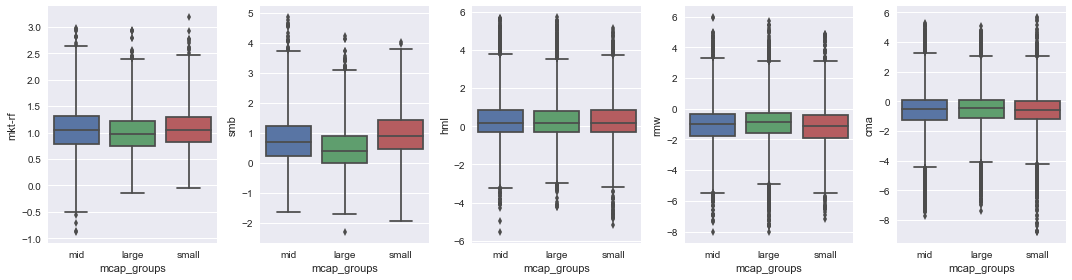

In [16]:
def box_plot(dataframe, features, group, 
             nrows, ncols, fwd_ret_horizon, figsize, quantiles=5):
    """
    dataframe: df with all data to be visualized
        features: Attributes / columns within the dataframe
    group: Categorical classifier 
    nrows/ncols: number of rows & columns for the charts
    fwd_ret_horizon: input the dependent (target) variable for multivariate plotting
    figsize: size of the plots being output
    quantiles: Sets number of quantiles for multivariate plots
    """
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for feature, ax in zip(features, axes.flatten()):
        if fwd_ret_horizon is None:
            sns.boxplot(x=group, y=str(feature), data=dataframe.dropna(), 
                        orient='v', whis=2.5, ax=ax)    
            
        else:            
            df = dataframe[[feature, fwd_ret_horizon]].copy()  
            df[str(feature)+'_quantiles'] = df.groupby(level=0)[feature]\
            .transform(lambda x: pd.qcut(x, 
                                         q=quantiles,
                                         duplicates='drop',
                                         labels=False))    
            
            sns.boxplot(y=fwd_ret_horizon, x=str(feature)+'_quantiles', 
                        data=df.dropna(), orient='v', whis=2.5, ax=ax)    
    
    fig.tight_layout()
    
box_plot(resampled_df, ff_factors, group='mcap_groups', 
         nrows=1, ncols=5, fwd_ret_horizon=None, figsize=(15, 4), quantiles=5)

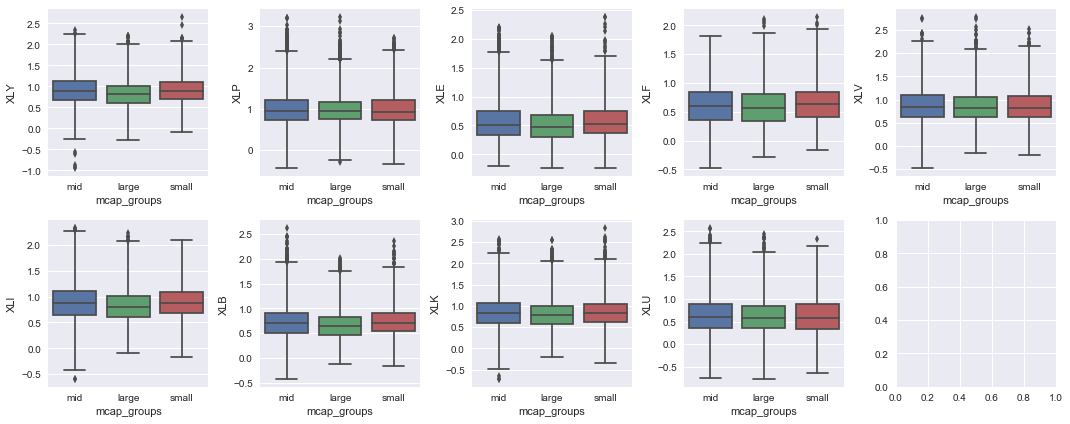

In [17]:
box_plot(resampled_df, sector_betas, group='mcap_groups', 
         nrows=2, ncols=5, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

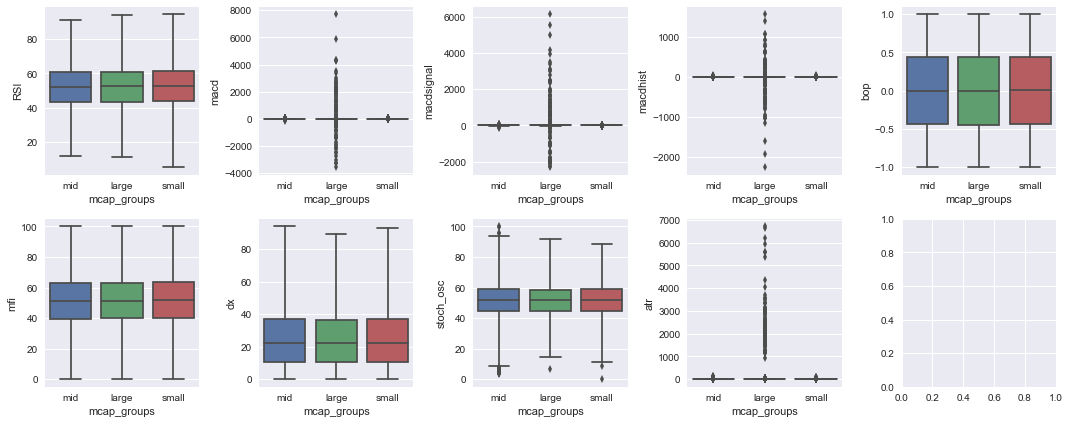

In [18]:
box_plot(resampled_df, technical_factors, group='mcap_groups', 
         nrows=2, ncols=5, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

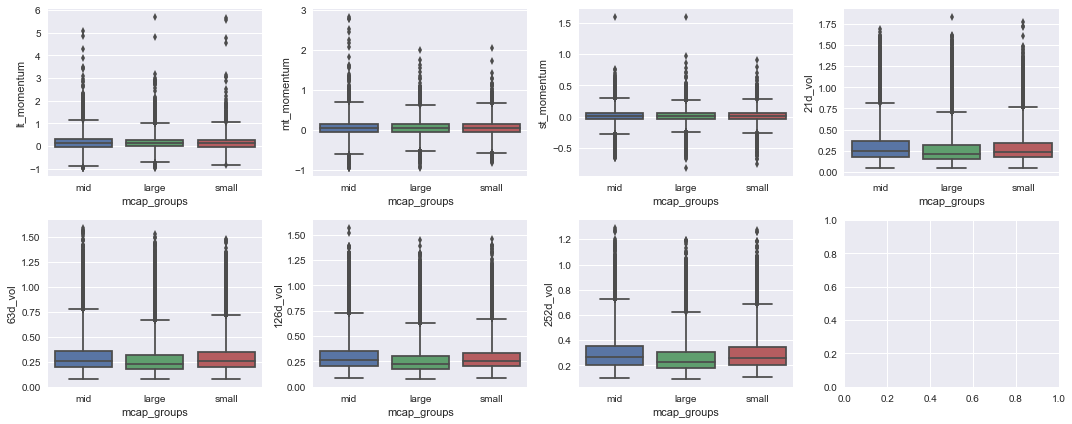

In [19]:
box_plot(resampled_df, momentum_vol, group='mcap_groups', 
         nrows=2, ncols=4, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

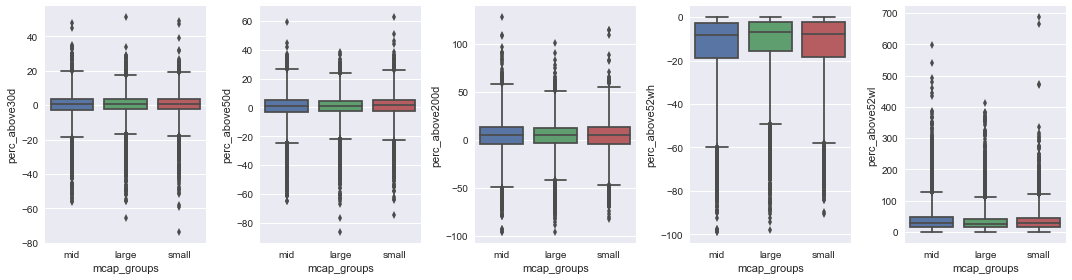

In [20]:
box_plot(resampled_df, pricing_factors, group='mcap_groups', 
         nrows=1, ncols=5, fwd_ret_horizon=None, figsize=(15, 4), quantiles=5)

## Treat outliers using the [interquartile range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range)

In [35]:
def iqr(x, q):
    q1, q3 = np.percentile(x.dropna(), q)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return x.clip(lower_bound, upper_bound)

all_factors = all_factors.groupby(level=0).transform(lambda x: iqr(x, [25, 75]))

## Transform heavily skewed features

- dx
- 21d_vol
- 63d_vol
- 126d_vol
- 252d_vol
- perc_above52wh
- perc_above52wl

In [36]:
all_factors[['dx']] = all_factors[['dx']].apply(lambda x: np.log(x + 1.))

all_factors[['21d_vol', 
             '63d_vol', 
             '126d_vol', 
             '252d_vol']] = all_factors[['21d_vol', 
                                         '63d_vol', 
                                         '126d_vol', 
                                         '252d_vol']].apply(lambda x: np.log(x + 1.))

all_factors[['perc_above52wh']] = all_factors[['perc_above52wh']].apply(lambda x: np.log(x / 100. + 1))

all_factors[['perc_above52wl']] = all_factors[['perc_above52wl']].apply(lambda x: np.log(x / 100. + 1))

Resample data with new outlier handling in place

In [37]:
num_samples = 100
random_dates = all_factors.sample(num_samples, 
                                  random_state=2).index.get_level_values(0).unique()
resampled_df = all_factors[all_factors.index\
                           .get_level_values(0).isin(random_dates)]

Re-run histograms to test the distributions after treating outliers and applying log transformations to the factors listed above. 

The distributions shown below are significantly reined in relative to their make-up prior to applying the IQR method and the log-normal adjustments.

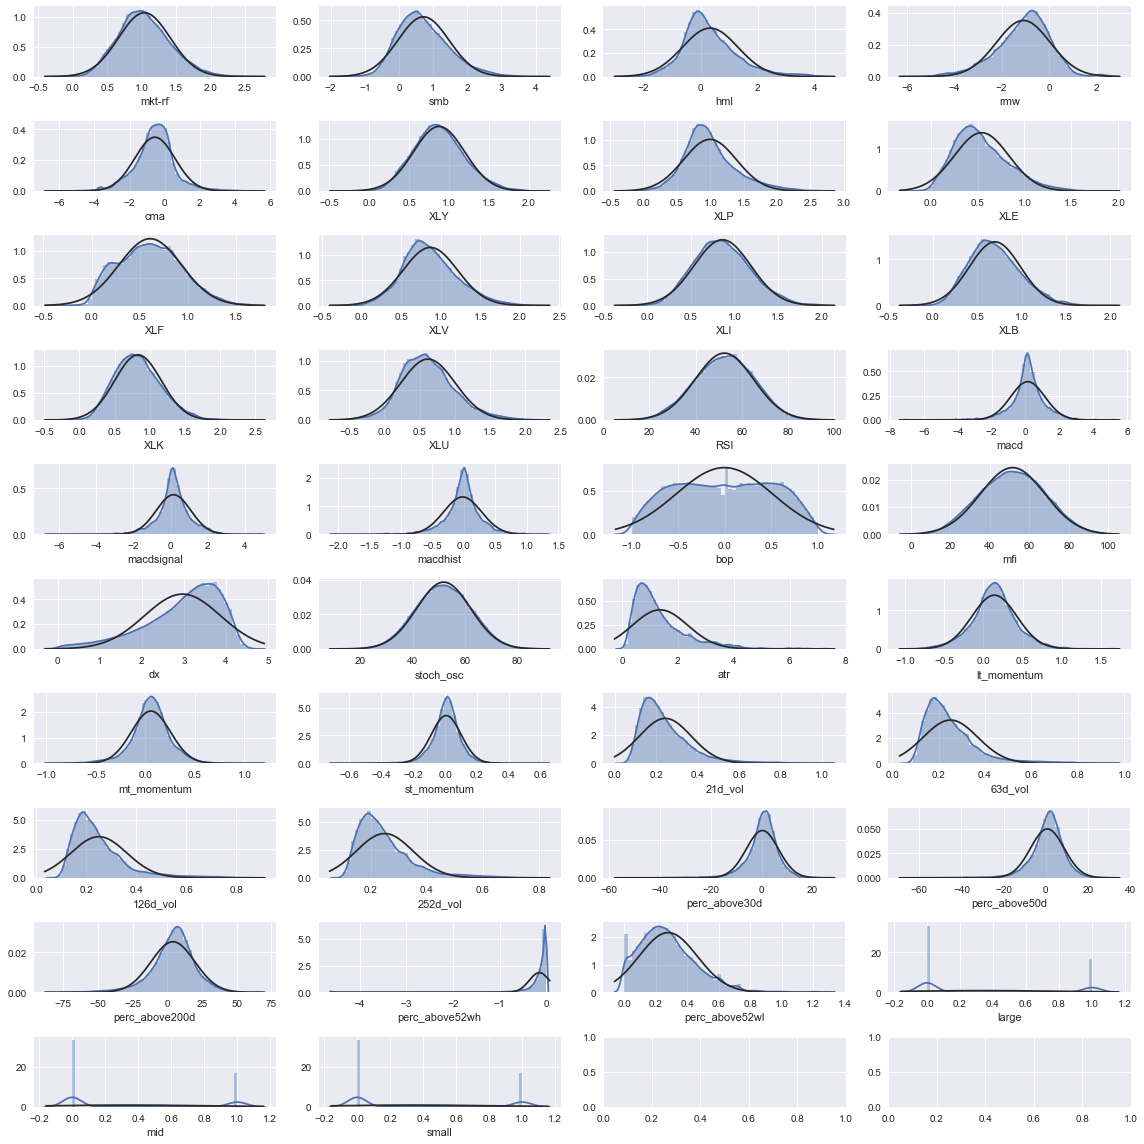

In [38]:
mask = features
ncols = 4
nrows = -(-len(mask)//ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16), sharex=False)
for d, ax in zip(mask, axes.flat):
    sns.distplot(resampled_df[d].dropna(), ax=ax, bins=50, fit=norm)

plt.tight_layout()

## Visualize Correlations

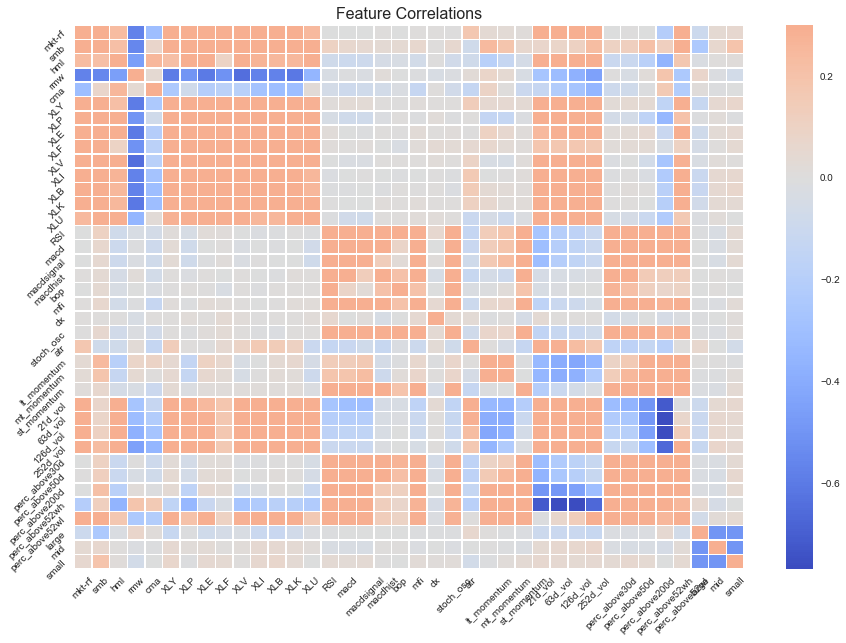

In [24]:
corrs = resampled_df[features].corr()
fig, ax = plt.subplots(figsize=(15,10)) 

sns.heatmap(corrs, 
            vmax=.3, 
            center=0, 
            cmap='coolwarm', 
            square=False, 
            linewidths=.5, 
            annot=False, 
            cbar_kws={'shrink': 1.})
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 
plt.title('Feature Correlations', fontsize=16)
plt.show()

### Identify all correlations above and below +/- .5

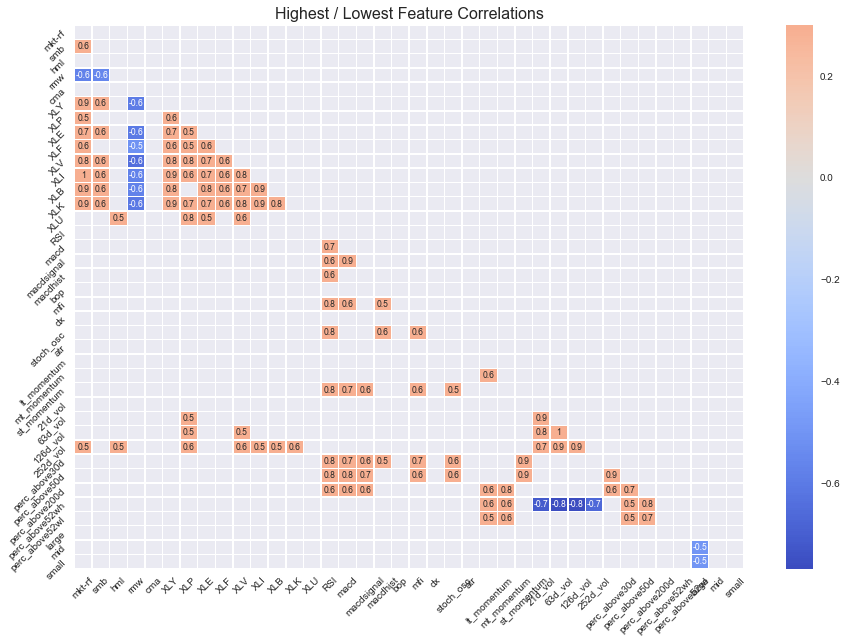

In [25]:
fig, ax = plt.subplots(figsize=(15,10)) 
lower_corrs = corrs.where(np.tril(np.ones(corrs.shape), 
                                  k=-1).astype(np.bool))

corr_threshold = .5
sns.heatmap(lower_corrs[lower_corrs.abs() > corr_threshold], 
            vmax=.3, 
            center=0, 
            cmap='coolwarm', 
            square=False, 
            linewidths=.5, 
            annot=True, fmt='.1g', 
            annot_kws={"size": 8.5}, 
            cbar_kws={'shrink': 1.})
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 
plt.title('Highest / Lowest Feature Correlations', fontsize=16)
plt.show()

### Identify top 10 highest correlated features

In [31]:
lower_corrs.unstack().sort_values(ascending=False)[:10]

mkt-rf         XLI              0.958386
63d_vol        126d_vol         0.953478
macd           macdsignal       0.947042
perc_above30d  perc_above50d    0.941215
st_momentum    perc_above30d    0.933572
126d_vol       252d_vol         0.929580
mkt-rf         XLB              0.928732
               XLY              0.924504
XLI            XLB              0.915417
XLY            XLI              0.912206
dtype: float64

### Identify top 10 lowest correlated features

In [32]:
lower_corrs.unstack().sort_values(ascending=True)[:10]

63d_vol   perc_above52wh   -0.768415
126d_vol  perc_above52wh   -0.766666
21d_vol   perc_above52wh   -0.714634
252d_vol  perc_above52wh   -0.669312
rmw       XLV              -0.640159
          XLK              -0.605771
          XLE              -0.602731
          XLY              -0.593851
          XLB              -0.575824
          XLI              -0.572605
dtype: float64

***
<a id='modelcte'></a>
# Model Construction, Tuning, and Evaluation

Up to this point, we have:

    1) Collected our data
    2) Engineered features
    3) Explored relationships in our data
    4) Identified & treated outliers
    5) Normalized our distributions where needed
    6) Defined our target variable

Now that our dataset is intact, we can begin building our suite of models to predict the cross-section of asset returns. First, we should discuss cross-validation and how we will go about creating in and out of sample partitions within our dataset to mitigate overfitting & look-ahead bias.

## Cross-Validation

Cross-validation (cv) is an integral component of machine learning. With a variety of techniques available (some referenced below), cv can be used to help practitioners train models and make predictions while curbing the effect of biases. This often comes in the form of generalizing the problem vs. introducing a high degree of variance into the study at hand. 

Financial time-series are non-stationary by definition and have temporal properties that need to be considered. Many of the statistical techniques being applied today operate under the assumption of normality & stationarity, so we could have our work cut out for us in applying a variety of statistically based models to form predictions. Going back to cv, some solutions we can pursue include:

- Grouping similar market regimes together and applying cv to similar environments


- Another would be to train and test a model using what is commonly referred to as a `walk-forward` model$_{1}$. Sci-kit learn has implemented this method in `TimeSeriesSplit`. 


`TimeSeriesSplit` is an excellent choice to carry out cross-validation when the dataset being analyzed has temporal dependencies that need to be respected. I began using `TimeSeriesSplit` and noticed it wasn't properly cross-validating the dataset due to the cross-sectional nature of our time-series (e.g. we have multiple securities in our sample on each period). To get around some of the issues I ran into with `TimeSeriesSplit`, I constructed my own user-defined function called `BatchWalkForwardCV`. `BatchWalkForwardCV` is a wrapper around `TimeSeriesSplit` that accounts for time-series datasets with multiple records per date.

In addition to properly cross-validating our models, `BatchWalkForwardCV` also utilizes sci-kit learn's machine learning `pipelines` and `RandomizedSearchCV` to identify our optimal parameters from the hyperparameter space.

$_{1}$ [Machine Learning Mastery: backtest ml models](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

---------------
### Standard Cross-validation Techniques 

Below is an example of a standard cross-validation technique known as k-folds cross-validation. More information on k-folds can be found by selecting the attached hyperlink. For now, we should think about the advantages and disadvantages when applying this framework to a non-stationary financial time-series. For this project, I chose to implement a cross-validation scheme that creates training and test windows on a rolling, walk forward basis. As mentioned earlier, many practitioners implement models similar to k-folds for time-series forecasting, where similar regimes are grouped together for training. Those schemes, while robust, are impossible to recreate out of sample and for that reason I chose to go in a different direction.

<img src="https://i.stack.imgur.com/YWgro.gif">
 

**Source:** [StackExchange](https://stats.stackexchange.com/questions/1826/cross-validation-in-plain-english)


---------------
### Time-series Cross-Validation Methods

For our example we'll be moving forward with a time-series cross-validation model, much like what sci-kit learn provides with `TimeSeriesSplit`. Our implementation of this cross-validation model has been modified to handle panels of data vs individual records. In addtion, we will be capping the number of historical periods at 21-days vs. using an expanding window. This was done primarily to keep the problem tractable given the density of the dataset.



<img src="https://i.stack.imgur.com/fXZ6k.png">


**Source:** [StackExchange](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)


**Sources:** 
- [AFIT Data Science Lab](https://afit-r.github.io/ts_benchmarking)
- [Towards Data Science](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)
- [Rob J Hyndman](https://robjhyndman.com/hyndsight/tscv/)
- [Sklearn - TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)


# Model Evaluation

After creating appropriate training and test sets for our data, we should consider how to best evaluate the efficacy of our models. Often times accuracy isn't the best metric for identifying the best model. Depending on the model being built, and the problem being solved, we may need a higher focus on the precision, recall, or both (F1 score).

### Accuracy, Precision, Recall, and F1


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png">


We will use the F-Score to measure the accuracy of our models.

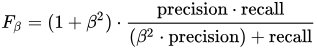


Source: [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

In [11]:
import tensorflow
from sklearn.model_selection import TimeSeriesSplit

In [12]:
#Checks for GPU
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [13]:
#Should be ~9x my pc
import multiprocessing
multiprocessing.cpu_count()

4

The cell below was used to test a variety of walk forward window lengths using `TimeSeriesSplit`. The final model we settled on usest 10 splits and a max training size of 21, which results in a 21-day training period that takes place on an annual basis. The resulting model is then used to predict the target variable for the subsequent 264 days.

In [16]:
tscv = TimeSeriesSplit(n_splits=10, max_train_size=21)
test_dates = all_factors.index.get_level_values(0).unique()
for train_index, test_index in tscv.split(test_dates):
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    print(
        'Len Train: {}'.format(len(train_index)),
        'Len Test: {}'.format(len(test_index))
    )
    print("   -Train:", all_factors.index.get_level_values(0).unique()[train_index][0],
          all_factors.index.get_level_values(0).unique()[train_index][-1]
         )
    
    print("   -Test:", all_factors.index.get_level_values(0).unique()[test_index][0],
          all_factors.index.get_level_values(0).unique()[test_index][-1]
         )

Len Train: 21 Len Test: 264
   -Train: 2008-01-07 2008-02-05
   -Test: 2008-02-06 2009-02-25
Len Train: 21 Len Test: 264
   -Train: 2009-01-27 2009-02-25
   -Test: 2009-02-26 2010-03-17
Len Train: 21 Len Test: 264
   -Train: 2010-02-17 2010-03-17
   -Test: 2010-03-18 2011-04-06
Len Train: 21 Len Test: 264
   -Train: 2011-03-09 2011-04-06
   -Test: 2011-04-07 2012-04-26
Len Train: 21 Len Test: 264
   -Train: 2012-03-28 2012-04-26
   -Test: 2012-04-27 2013-05-20
Len Train: 21 Len Test: 264
   -Train: 2013-04-22 2013-05-20
   -Test: 2013-05-21 2014-06-10
Len Train: 21 Len Test: 264
   -Train: 2014-05-12 2014-06-10
   -Test: 2014-06-11 2015-06-30
Len Train: 21 Len Test: 264
   -Train: 2015-06-02 2015-06-30
   -Test: 2015-07-01 2016-07-20
Len Train: 21 Len Test: 264
   -Train: 2016-06-21 2016-07-20
   -Test: 2016-07-21 2017-08-09
Len Train: 21 Len Test: 264
   -Train: 2017-07-12 2017-08-09
   -Test: 2017-08-10 2018-08-29


**Define features and targets**

In [17]:
#Features
ml_features = ['p_gt_30d', 
               'p_gt_50d', 
               'p_gt_200d', 
               '30d_gt_50d', 
               '50d_gt_200d', 
               'perc_above30d',
               'perc_above50d', 
               'perc_above200d', 
               'perc_above52wh', 
               'perc_above52wl', 
               'lt_momentum', 
               'mt_momentum',
               'st_momentum', 
               '21d_vol', 
               '63d_vol', 
               '126d_vol',
               '252d_vol', 
               'RSI', 
               'macd', 
               'macdsignal', 
               'macdhist', 
               'bop', 
               'mfi', 
               'dx', 
               'stoch_osc', 
               'atr', 
               'mkt-rf', 
               'smb', 
               'hml', 
               'rmw', 
               'cma', 
               'XLY', 
               'XLP', 
               'XLE', 
               'XLF',
               'XLV', 
               'XLI', 
               'XLB', 
               'XLK', 
               'XLU', 
               'large',
               'mid', 
               'small']

#Target variable
targets = ['fwdret_63d_target']

## Import libraries for our models

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

from sklearn import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    fbeta_score, 
    precision_score, 
    make_scorer, 
    classification_report
)
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from FinancialML_utils import BatchWalkForwardCV #Import custom library

## 1st Model: Logistic Regression 

Using `BatchWalkForwardCV`, we will run a logistic regression through a pipeline, standardize the feature space, and output a series of predictions, symbols, and scores. The model is highly verbose and also generates an analysis of the results.

In [16]:
params = {'C': np.logspace(-3, 3, 5), 
          'penalty': ['l1', 'l2']}

lr_preds, lr_symbols, lr_oos_dates, lr_test_scores, lr_train_scores, lr_model = BatchWalkForwardCV(
    df=all_factors.dropna(), 
    model=LogisticRegression(random_state=42), 
    param_grid=params, 
    n_splits=10,#22, 
    n_iter=10,
    features=ml_features, 
    target=targets, 
    max_train_size=21,#750, 
    scaler=MinMaxScaler(),
    verbose=True
)

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

#=================#
Best CV Score: 0.64
Test Score: 0.39
#=================#
Best Params: {'clf__penalty': 'l2', 'clf__C': 1.0}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2008-02-06 - To: 2009-02-25
 
               precision    recall  f1-score   support

Underperform       0.50      0.78      0.61     54147
  Outperform       0.49      0.21      0.29     54087

   micro avg       0.50      0.50      0.50    108234
   macro avg       0.49      0.50      0.45    108234
weighted avg       0.49      0.50      0.45    108234

#============================================#
#==

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

#=================#
Best CV Score: 0.69
Test Score: 0.38
#=================#
Best Params: {'clf__penalty': 'l1', 'clf__C': 1000.0}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2016-07-21 - To: 2017-08-09
 
               precision    recall  f1-score   support

Underperform       0.52      0.90      0.66     80167
  Outperform       0.60      0.15      0.24     79342

   micro avg       0.53      0.53      0.53    159509
   macro avg       0.56      0.53      0.45    159509
weighted avg       0.56      0.53      0.45    159509

#===========================================

Gather predictions and test the persistency of the model over the 10 year out of sample period. Given the relatively low computational effort required, and quick setup, the logistic regression produced a viable model with a number of periods with an F1 score greater than 50%. The biggest drawback we see through the plot below is the high degree of variability in the F1 score. In some periods we see an F1 score lower than 40% while others approach 60%.

In [17]:
lr_predsdf = pd.DataFrame(
    {'pred': np.concatenate(lr_preds)
    }, 
    index=[np.concatenate(lr_oos_dates),
           np.concatenate(lr_symbols)]
)

lr_predsdf.index.names = ['date', 'ticker']

lr_data = pd.merge(
    lr_predsdf,
    all_factors[['fwdret_63d']],
    how='left',
    left_index=True,
    right_index=True
)

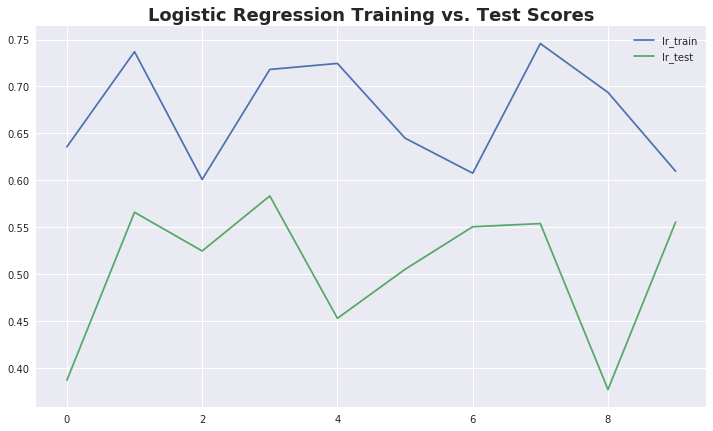

In [195]:
#Annual preds - 1m training
lr_scores = pd.DataFrame(
    {'lr_train': lr_train_scores, 
     'lr_test': lr_test_scores}
)
lr_scores.plot(figsize=(12,7))
plt.title(
    'Logistic Regression Training vs. Test Scores',
    fontsize=18, 
    fontweight='bold'
)
plt.show()

## 2nd Model: Random Forest

We constructed a diverse parameter space for the random forest classifier with the inputs shown below. Similar to what we reviewed above, this model will be trained with `BatchWalkForwardCV` and output a series of scores and diagnostics around our model so we can analyze the results.

In [23]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, 
                                            stop = 400, 
                                            num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 
                                         110,
                                         num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 15, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_params = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap
            }

In [24]:
#Add feature importance to BatchWalkForwardCV can use try & except
rf_preds, rf_symbols, rf_oos_dates, rf_test_scores, rf_train_scores, rf_model = BatchWalkForwardCV(
    df=all_factors.dropna(), 
    model=RandomForestClassifier(random_state=42), 
    param_grid=rf_params, 
    n_splits=10,#22, 
    n_iter=40,
    features=ml_features, 
    target=targets, 
    max_train_size=21,#750, 
    scaler=MinMaxScaler(),
    verbose=True
)

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=110, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=356, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

#=================#
Best CV Score: 0.87
Test Score: 0.48
#=================#
Best Params: {'clf__n_estimators': 356, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 110, 'clf__bootstrap': False}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2008-02-06 - To: 2009-02-25
 
               precision    recall  f1-score   support

Underperform       0.52      0.68      0.59     54

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

#=================#
Best CV Score: 0.93
Test Score: 0.54
#=================#
Best Params: {'clf__n_estimators': 140, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 80, 'clf__bootstrap': False}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2015-07-01 - To: 2016-07-20
 
               precision    recall  f1-score   support

Underperform       0.54      0.63      0.58     7389

In [25]:
rf_predsdf = pd.DataFrame(
    {'pred': np.concatenate(rf_preds)
    }, 
    index=[np.concatenate(rf_oos_dates),
           np.concatenate(rf_symbols)]
)

rf_predsdf.index.names = ['date', 'ticker']

rf_data = pd.merge(
    rf_predsdf,
    all_factors[['fwdret_63d']],
    how='left',
    left_index=True,
    right_index=True
)

After gathering the predictions, we can test the persistency of the F1 scores on the training and test data over the 10 year period. The random forest model solved one problem for us but introduced another: our scores are much less volatile compared to those produced by the logistic regression, however it appears our model did not generalize the problem well and as a result a large amount of variance was introduced. 

In a future study it would help to explore a parameter space that facilitates generalizing the problem more. For now, I am encouraged that our final model produces F1 scores that have low variability and are consistently above 50%. This should pay dividends when we get to testing these predictions out of sample by making allocations to companies based on the model output.

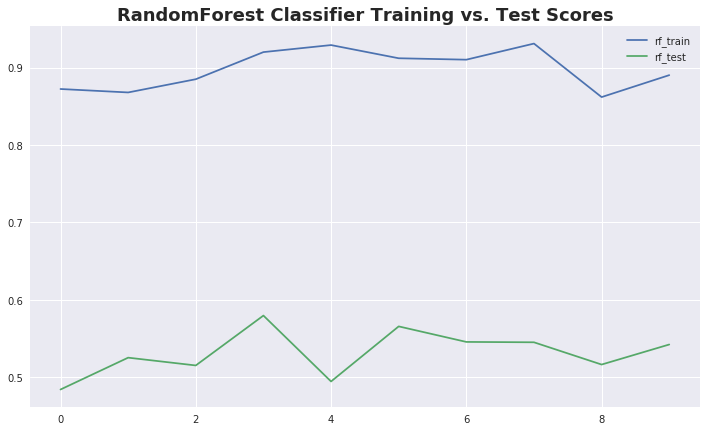

In [197]:
#Annual preds - 1m training
rf_scores = pd.DataFrame(
    {'rf_train': rf_train_scores, 
     'rf_test': rf_test_scores}
)
rf_scores.plot(figsize=(12,7))
plt.title(
    'RandomForest Classifier Training vs. Test Scores',
    fontsize=18, 
    fontweight='bold'
)
         
plt.show()

Next, I wanted to evaluate the feature importance plots for this model. In this first plot, we see the feature importance's for the 10th, and final, year of our model. Broadly speaking, it's interesting to see the emphasis placed on sectors (XL* factors) and styles.

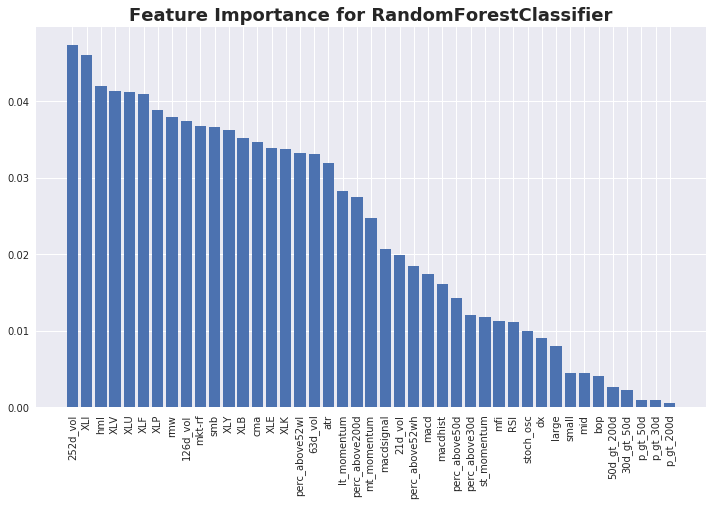

In [100]:
importance = rf_model[9].best_estimator_.named_steps['clf'].feature_importances_
indices = np.argsort(importance)[::-1]
importance = importance[indices]
features = np.array(ml_features)[indices]

size = np.arange(len(importance))

#Plot features for RF
fig = plt.figure(figsize=(12,7))
plt.bar(size, importance)
plt.xticks(size, features, rotation='vertical')
plt.title(
    'Feature Importance for RandomForestClassifier', 
    fontsize=18, 
    fontweight='bold'
)
plt.show()

After looking at the feature importance plot for the 10th period, I wanted to get a closer look at the mean feature importance's across the 10-year horizon of the study. This plot offers us more perspective into the factors with the largest effect on our model results.

Similar to the one period we looked at in isolation, here we see a large emphasis placed on sectors, styles, and volatility. By and large, I'm seeing a lower dependence on the technical factors that comprised the majority of the feature space.

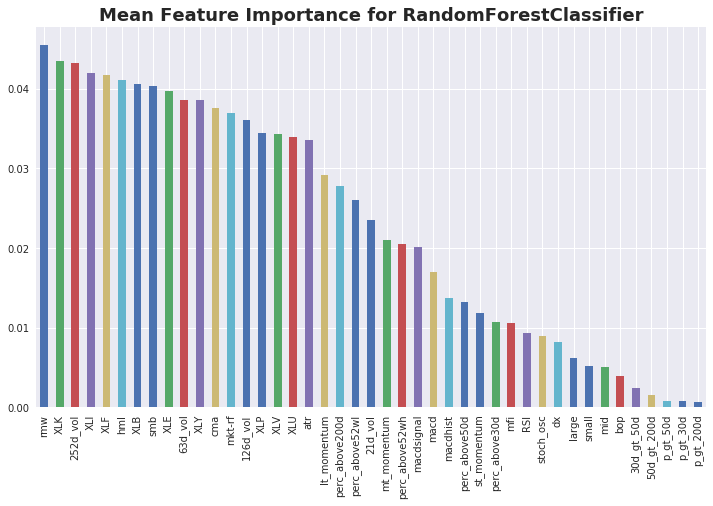

In [102]:
mean_importance = []
for split in range(len(rf_model)):
    mean_importance.append(
        rf_model[split].best_estimator_.named_steps['clf'].feature_importances_
    ) 

mean_importance_df = pd.DataFrame(
    mean_importance, columns=ml_features
).T
mean_importance_df.apply(
    lambda x: x.mean(), 
    axis=1).sort_values(ascending=False).plot(kind='bar', 
                                              figsize=(12,7)
                                             )
plt.title(
    'Mean Feature Importance for RandomForestClassifier', 
    fontsize=18, 
    fontweight='bold'
)
plt.show()

## 3rd Model: Adaboost

AdaBoost is the third model we'll be using to produce predictions. The setup is similar to what we've previously reviewed with `BatchWalkForwardCV` but with a slightly different parameter grid.

In [103]:
from sklearn.ensemble import AdaBoostClassifier

#Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 10, 
                                            stop = 400, 
                                            num = 10)]
#Learning rate
learning_rate = [x for x in np.linspace(0.001, 1, 10)]

# Create the random grid
adaboost_params = {'n_estimators': n_estimators,
                   'learning_rate': learning_rate}

In [106]:
#Add feature importance to BatchWalkForwardCV can use try & except
ab_preds, ab_symbols, ab_oos_dates, ab_test_scores, ab_train_scores, ab_model = BatchWalkForwardCV(
    df=all_factors.dropna(), 
    model=AdaBoostClassifier(base_estimator=RandomForestClassifier(), random_state=42), 
    param_grid=adaboost_params, 
    n_splits=10,#22, 
    n_iter=40,
    features=ml_features, 
    target=targets, 
    max_train_size=21,#750, 
    scaler=MinMaxScaler(),
    verbose=True
)

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min...,
            warm_start=False),
          learning_rate=0.001, n_estimators=270, random_state=42))])

#=================#
Best CV Score: 0.87
Test Score: 0.50
#=================#
Best Params: {'clf__n_estimators': 270, 'clf__learning_rate': 0.001}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2008-02-06 - To: 2009-02-25
 
               precision    recall  f1-score   support

Underperform       0.52      0.67      0.58     54147
  Outperform       0.53      0.38      0.45     54087

   micro avg       0.53      0.53      0.53    108234
   macro avg       0.53      0.52      0.52    108234
weighted avg       0.

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min...0,
            warm_start=False),
          learning_rate=0.445, n_estimators=96, random_state=42))])

#=================#
Best CV Score: 0.86
Test Score: 0.51
#=================#
Best Params: {'clf__n_estimators': 96, 'clf__learning_rate': 0.445}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2016-07-21 - To: 2017-08-09
 
               precision    recall  f1-score   support

Underperform       0.52      0.61      0.56     80167
  Outperform       0.53      0.44      0.48     79342

   micro avg       0.52      0.52      0.52    159509
   macro avg       0.52      0.52      0.52    159509
weighted avg       0.5

In [108]:
ab_predsdf = pd.DataFrame({'pred': np.concatenate(ab_preds)
                          }, 
                          index=[np.concatenate(ab_oos_dates),
                                 np.concatenate(ab_symbols)]
                         )

ab_predsdf.index.names = ['date', 'ticker']

ab_data = pd.merge(ab_predsdf,
                   all_factors[['fwdret_63d']],
                   how='left',
                   left_index=True,
                   right_index=True
                  )

The results are similar to that of the random forest classifier. The adaboost model hasn't generalized the training data well and as a result has introduced variance to the analysis. That said, and much like we discussed before, the test scores are impressive and are reasonable with respect to their variability. Given the complexity of the problem being addressed, I'm hesitate to think reducing the variance is going to improve the test scores much, if at all.

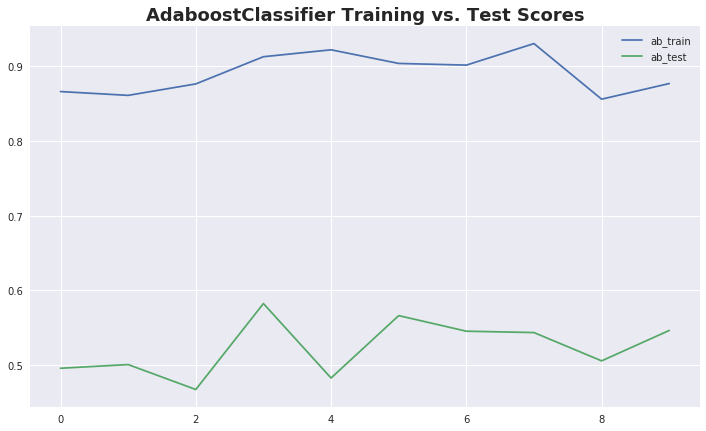

In [199]:
#Annual preds - 1m training
ab_scores = pd.DataFrame({'ab_train': ab_train_scores, 
                          'ab_test': ab_test_scores})

ab_scores.plot(figsize=(12,7))
plt.title('AdaboostClassifier Training vs. Test Scores',
          fontsize=18, 
          fontweight='bold')
plt.show()

As we did with the random forest classifier, we can view the feature importance plot for the adaboost model. There are slight differences in the features given the highest importance to the model, however there are more similarities than differences. As we saw with the random forest classifier, the driving factors in producing our predictions came down to sectors, styles, and volatility.

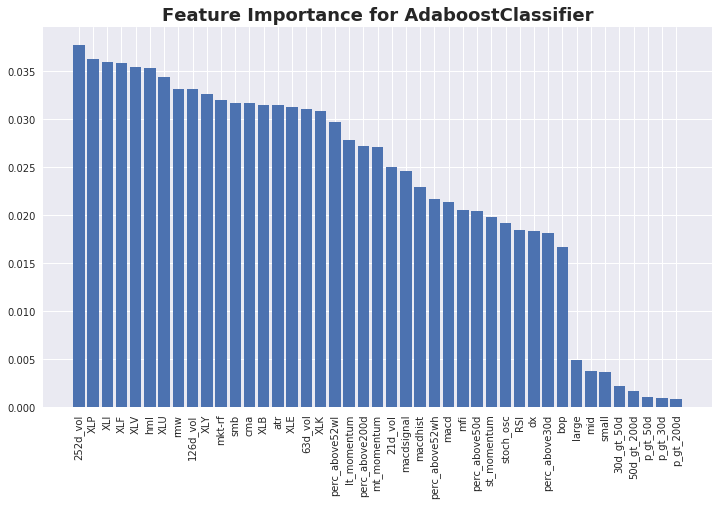

In [112]:
importance = ab_model[9].best_estimator_.named_steps['clf'].feature_importances_
indices = np.argsort(importance)[::-1]
importance = importance[indices]
features = np.array(ml_features)[indices]

size = np.arange(len(importance))

#Plot features for RF
fig = plt.figure(figsize=(12,7))
plt.bar(size, importance)
plt.xticks(size, features, rotation='vertical')
plt.title('Feature Importance for AdaboostClassifier', fontsize=18, fontweight='bold')
plt.show()

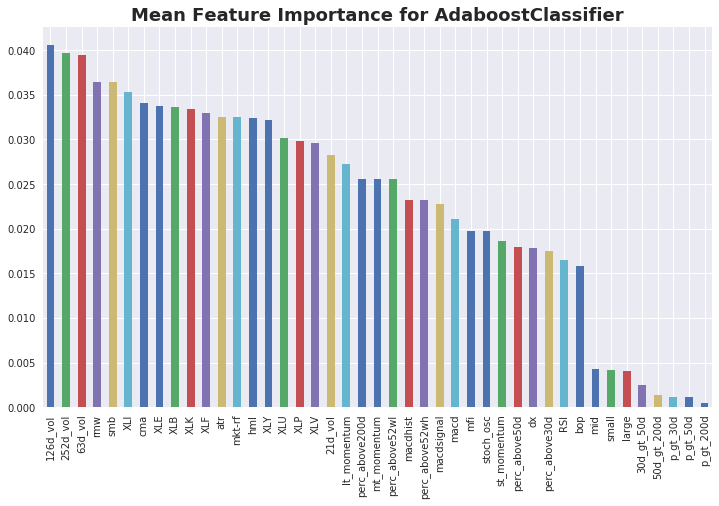

In [113]:
mean_importance = []
for split in range(len(ab_model)):
    mean_importance.append(ab_model[split].best_estimator_.named_steps['clf'].feature_importances_) 

mean_importance_df = pd.DataFrame(mean_importance, columns=ml_features).T
mean_importance_df.apply(lambda x: x.mean(), 
                         axis=1).sort_values(ascending=False).plot(kind='bar', 
                                                                   figsize=(12,7)
                                                                  )
plt.title('Mean Feature Importance for AdaboostClassifier', 
          fontsize=18, 
          fontweight='bold')
plt.show()

***
## Model Comparison

In this section we will compare the scores produced by the logistic, random forest, and adaboost models. The following points become evident by analyzing the results:

1) Both the random forest and adaboost classifiers do not generalize the training data well

2) The logistic regression produces respectable F1 scores on the test set, however there's more variability in the results when compared to the other two models

3) The performance of the models is somewhat expected, where the random forest produced the best F1 scores followed by the adaboost and logistic regression models

In [162]:
training = {
    'lr_train_scores': lr_train_scores,
    'rf_train_scores': rf_train_scores,
    'ab_train_scores': ab_train_scores
}

training_scores = pd.DataFrame(training)

test = {
    'lr_test_scores': lr_test_scores,
    'rf_test_scores': rf_test_scores,
    'ab_test_scores': ab_test_scores
}

test_scores = pd.DataFrame(test)

print("Training Scores: ")
print(training_scores, "\n")
print("Test Scores: ")
print(test_scores)

Training Scores: 
   lr_train_scores  rf_train_scores  ab_train_scores
0         0.635595         0.872222         0.865881
1         0.737005         0.867775         0.860784
2         0.600801         0.884880         0.876104
3         0.718105         0.919910         0.912475
4         0.724509         0.928995         0.921729
5         0.644849         0.911956         0.903496
6         0.607515         0.910122         0.901245
7         0.745669         0.930927         0.930059
8         0.693642         0.861769         0.855713
9         0.609566         0.890137         0.876597 

Test Scores: 
   lr_test_scores  rf_test_scores  ab_test_scores
0        0.386793        0.483909        0.495848
1        0.565880        0.525061        0.500771
2        0.524592        0.515001        0.467421
3        0.583249        0.579456        0.582363
4        0.452815        0.494300        0.482808
5        0.505023        0.565465        0.566241
6        0.550429        0.545400

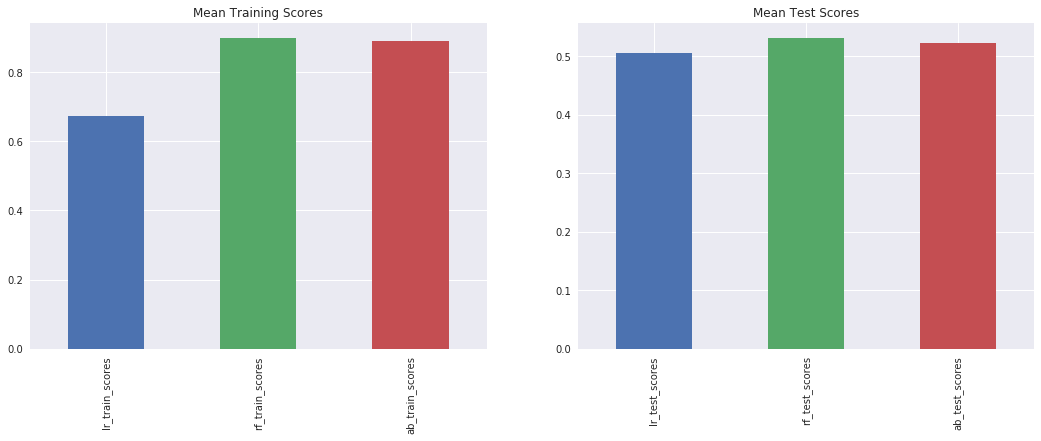

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))

training_scores.mean().plot(kind='bar', title='Mean Training Scores', ax=ax1)
test_scores.mean().plot(kind='bar', title='Mean Test Scores', ax=ax2)
plt.show()

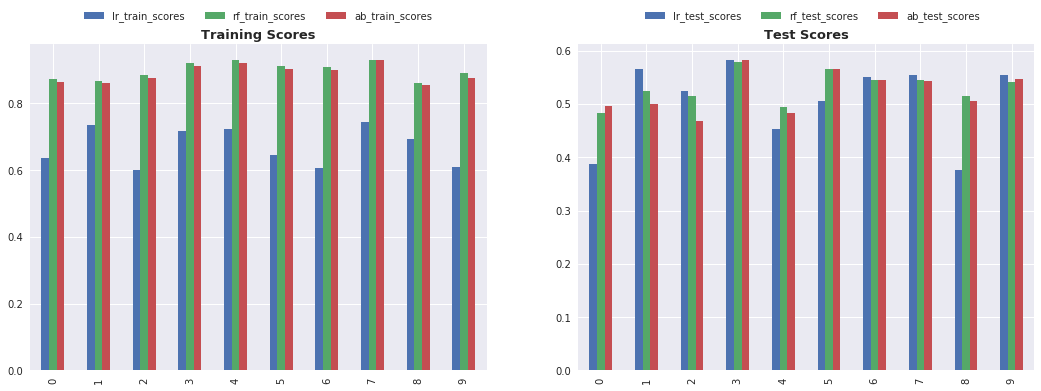

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))

training_scores.plot(kind='bar', ax=ax1)
ax1.set_title(
    'Training Scores',
    fontsize=13, 
    fontweight='bold'
)
ax1.legend(
    training_scores.columns.tolist(), 
    ncol=4, 
    bbox_to_anchor=(-0.1, .95, 1, .18)
)

test_scores.plot(kind='bar', ax=ax2)
ax2.set_title(
    'Test Scores',
    fontsize=13, 
    fontweight='bold'
)
ax2.legend(
    test_scores.columns.tolist(), 
    ncol=4, 
    bbox_to_anchor=(-0.1, .95, 1, .18)
)

plt.show()

#### All predictions are being written to csv so they can be referenced within Quantopian. 

In [233]:
#lr_data.to_csv('lr_preds.csv')
#rf_data.to_csv('rf_preds.csv')
#ab_data.to_csv('ab_preds.csv')

# Setup Time-Series Forecasts for Keras

The two models being used here are:

1) Feed forward neural network

2) Long-short term memory neural network

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


**Define F-Score**

Helpful f-beta score for use with Keras sourced from [Kaggle](https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras)

In [21]:
from keras import backend as K

#Define f-beta score
def fbeta_score(y_true, y_pred, threshold_shift=0):
    beta = 0.5

    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

## 4th Model: Feed-Forward Neural Network

The `feedforward_nn` user-defined function (UDF) was created to create a flexible architecture for this model. That UDF is referenced in the next cell which adjusts the data for a walk-forward cross-validation model that leverages `TimeSeriesSplit` from scikit-learn.

The final architecture being employed consists of the following parameters:

- 5 hidden layers with 64 units (neurons)
- Dropout probability: 40%
- Epochs: 100
- Batch size: 32
- Activation function: Sigmoid
- Loss function: Binary crossentropy 
- Optimizer: Adam

In [25]:
def feedforward_nn(x, y, validation_data, epochs, batch_size, num_layers, num_units, dropout):
    
    model = Sequential()

    for _ in range(num_layers):
        model.add(Dense(num_units))
        model.add(Dropout(dropout))
    
    model.add(Dense(2, 
                    activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', fbeta_score])
    
    ff_nn = model.fit(x=x, 
                      y=y,
                      epochs=epochs, 
                      validation_data=validation_data,
                      batch_size=batch_size, 
                      shuffle=False)
    
    predictions = model.predict_classes(validation_data[0])
    scores = model.evaluate(validation_data[0], validation_data[1])
    metric_names = model.metrics_names
        
    return ff_nn, predictions, scores, metric_names

In [27]:
#Testing keras
ff_preds = []
ff_symbols = []
ff_oos_dates = []
ff_scores = []
ff_metric_names = []
ff_nn = []
df = all_factors.dropna()
X = all_factors.dropna().unstack()[ml_features]
y = all_factors.dropna().unstack()[targets]
for train_index, test_index in tscv.split(df.unstack()[ml_features]):
    X_train, X_test, y_train, y_test = X.iloc[train_index].stack(),\
    X.iloc[test_index].stack(),\
    y.iloc[train_index].stack(),\
    y.iloc[test_index].stack()
    
    #Store symbols & dates here
    #--------------------------
    ff_symbols.append(X_test.index.get_level_values(1))
    ff_oos_dates.append(X_test.index.get_level_values(0))

    #Scale features
    #--------------
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Run neural network
    #------------------
    #convert targets to categorical
    y_train_categorical = to_categorical(y_train, num_classes=2) 
    y_test_categorical = to_categorical(y_test, num_classes=2)  
    
    #Store results
    #-------------
    results, predictions, scores, metric_names = feedforward_nn(
        x=X_train, 
        y=y_train_categorical, 
        validation_data=(X_test, y_test_categorical), 
        epochs=100,
        batch_size=32, 
        num_layers=5,
        num_units=64,
        dropout=.4
    )    
    
    #Save results
    #------------
    ff_preds.append(predictions)
    ff_nn.append(results)
    ff_scores.append(scores)
    ff_metric_names.append(metric_names)

Train on 8546 samples, validate on 108234 samples
Epoch 1/100
8546/8546 [==============================] - 6s 744us/step - loss: 0.7418 - acc: 0.5489 - fbeta_score: 0.4732 - val_loss: 0.7201 - val_acc: 0.4939 - val_fbeta_score: 0.4808
Epoch 2/100
8546/8546 [==============================] - 6s 671us/step - loss: 0.6799 - acc: 0.5806 - fbeta_score: 0.5267 - val_loss: 0.7330 - val_acc: 0.4921 - val_fbeta_score: 0.4847
Epoch 3/100
8546/8546 [==============================] - 6s 674us/step - loss: 0.6643 - acc: 0.6037 - fbeta_score: 0.5621 - val_loss: 0.7500 - val_acc: 0.4915 - val_fbeta_score: 0.4890
Epoch 4/100
8546/8546 [==============================] - 6s 671us/step - loss: 0.6568 - acc: 0.6132 - fbeta_score: 0.5803 - val_loss: 0.7449 - val_acc: 0.4888 - val_fbeta_score: 0.4868
Epoch 5/100
8546/8546 [==============================] - 6s 673us/step - loss: 0.6511 - acc: 0.6227 - fbeta_score: 0.5930 - val_loss: 0.7617 - val_acc: 0.4889 - val_fbeta_score: 0.4859
Epoch 6/100
8546/8546 [==

Epoch 45/100
8546/8546 [==============================] - 6s 705us/step - loss: 0.6238 - acc: 0.6575 - fbeta_score: 0.6575 - val_loss: 0.7823 - val_acc: 0.4871 - val_fbeta_score: 0.4871
Epoch 46/100
8546/8546 [==============================] - 6s 673us/step - loss: 0.6258 - acc: 0.6512 - fbeta_score: 0.6512 - val_loss: 0.7831 - val_acc: 0.4871 - val_fbeta_score: 0.4871
Epoch 47/100
8546/8546 [==============================] - 6s 682us/step - loss: 0.6207 - acc: 0.6571 - fbeta_score: 0.6571 - val_loss: 0.7882 - val_acc: 0.4879 - val_fbeta_score: 0.4879
Epoch 48/100
8546/8546 [==============================] - 6s 672us/step - loss: 0.6216 - acc: 0.6577 - fbeta_score: 0.6577 - val_loss: 0.8248 - val_acc: 0.4881 - val_fbeta_score: 0.4881
Epoch 49/100
8546/8546 [==============================] - 6s 672us/step - loss: 0.6264 - acc: 0.6543 - fbeta_score: 0.6543 - val_loss: 0.8098 - val_acc: 0.4884 - val_fbeta_score: 0.4884
Epoch 50/100
8546/8546 [==============================] - 6s 671us/ste

8546/8546 [==============================] - 6s 671us/step - loss: 0.6204 - acc: 0.6598 - fbeta_score: 0.6598 - val_loss: 0.8100 - val_acc: 0.4899 - val_fbeta_score: 0.4899
Epoch 90/100
8546/8546 [==============================] - 6s 673us/step - loss: 0.6186 - acc: 0.6586 - fbeta_score: 0.6586 - val_loss: 0.7997 - val_acc: 0.4905 - val_fbeta_score: 0.4905
Epoch 91/100
8546/8546 [==============================] - 6s 670us/step - loss: 0.6178 - acc: 0.6587 - fbeta_score: 0.6587 - val_loss: 0.8312 - val_acc: 0.4912 - val_fbeta_score: 0.4912
Epoch 92/100
8546/8546 [==============================] - 6s 670us/step - loss: 0.6201 - acc: 0.6579 - fbeta_score: 0.6579 - val_loss: 0.8210 - val_acc: 0.4909 - val_fbeta_score: 0.4909
Epoch 93/100
8546/8546 [==============================] - 6s 673us/step - loss: 0.6184 - acc: 0.6600 - fbeta_score: 0.6600 - val_loss: 0.8067 - val_acc: 0.4902 - val_fbeta_score: 0.4902
Epoch 94/100
8546/8546 [==============================] - 6s 670us/step - loss: 0.6

8497/8497 [==============================] - 6s 712us/step - loss: 0.5329 - acc: 0.7465 - fbeta_score: 0.7465 - val_loss: 1.3009 - val_acc: 0.5481 - val_fbeta_score: 0.5481
Epoch 77/100
8497/8497 [==============================] - 6s 710us/step - loss: 0.5342 - acc: 0.7423 - fbeta_score: 0.7423 - val_loss: 1.2041 - val_acc: 0.5541 - val_fbeta_score: 0.5541
Epoch 78/100
8497/8497 [==============================] - 6s 710us/step - loss: 0.5346 - acc: 0.7431 - fbeta_score: 0.7431 - val_loss: 1.3141 - val_acc: 0.5512 - val_fbeta_score: 0.5512
Epoch 79/100
8497/8497 [==============================] - 6s 712us/step - loss: 0.5352 - acc: 0.7443 - fbeta_score: 0.7443 - val_loss: 1.2338 - val_acc: 0.5539 - val_fbeta_score: 0.5539
Epoch 80/100
8497/8497 [==============================] - 6s 709us/step - loss: 0.5325 - acc: 0.7436 - fbeta_score: 0.7436 - val_loss: 1.3813 - val_acc: 0.5483 - val_fbeta_score: 0.5483
Epoch 81/100
8497/8497 [==============================] - 6s 712us/step - loss: 0.5

9786/9786 [==============================] - 7s 711us/step - loss: 0.6636 - acc: 0.6034 - fbeta_score: 0.6034 - val_loss: 0.7070 - val_acc: 0.5023 - val_fbeta_score: 0.5023
Epoch 64/100
9786/9786 [==============================] - 7s 711us/step - loss: 0.6639 - acc: 0.6003 - fbeta_score: 0.6003 - val_loss: 0.7079 - val_acc: 0.5042 - val_fbeta_score: 0.5042
Epoch 65/100
9786/9786 [==============================] - 7s 711us/step - loss: 0.6620 - acc: 0.6027 - fbeta_score: 0.6027 - val_loss: 0.7032 - val_acc: 0.5048 - val_fbeta_score: 0.5048
Epoch 66/100
9786/9786 [==============================] - 7s 711us/step - loss: 0.6633 - acc: 0.5996 - fbeta_score: 0.5996 - val_loss: 0.7043 - val_acc: 0.5030 - val_fbeta_score: 0.5030
Epoch 67/100
9786/9786 [==============================] - 7s 729us/step - loss: 0.6605 - acc: 0.6079 - fbeta_score: 0.6079 - val_loss: 0.7092 - val_acc: 0.5034 - val_fbeta_score: 0.5034
Epoch 68/100
9786/9786 [==============================] - 7s 730us/step - loss: 0.6

Epoch 50/100
10267/10267 [==============================] - 7s 697us/step - loss: 0.5723 - acc: 0.7077 - fbeta_score: 0.7077 - val_loss: 0.7880 - val_acc: 0.5435 - val_fbeta_score: 0.5435
Epoch 51/100
10267/10267 [==============================] - 7s 697us/step - loss: 0.5703 - acc: 0.7094 - fbeta_score: 0.7094 - val_loss: 0.7784 - val_acc: 0.5461 - val_fbeta_score: 0.5461
Epoch 52/100
10267/10267 [==============================] - 7s 699us/step - loss: 0.5692 - acc: 0.7097 - fbeta_score: 0.7097 - val_loss: 0.7939 - val_acc: 0.5465 - val_fbeta_score: 0.5465
Epoch 53/100
10267/10267 [==============================] - 7s 699us/step - loss: 0.5683 - acc: 0.7084 - fbeta_score: 0.7084 - val_loss: 0.7999 - val_acc: 0.5437 - val_fbeta_score: 0.5437
Epoch 54/100
10267/10267 [==============================] - 7s 697us/step - loss: 0.5703 - acc: 0.7102 - fbeta_score: 0.7102 - val_loss: 0.7792 - val_acc: 0.5436 - val_fbeta_score: 0.5436
Epoch 55/100
10267/10267 [==============================] - 

10393/10393 [==============================] - 8s 733us/step - loss: 0.5675 - acc: 0.7164 - fbeta_score: 0.7164 - val_loss: 0.8860 - val_acc: 0.4614 - val_fbeta_score: 0.4614
Epoch 37/100
10393/10393 [==============================] - 8s 732us/step - loss: 0.5681 - acc: 0.7190 - fbeta_score: 0.7190 - val_loss: 0.9086 - val_acc: 0.4582 - val_fbeta_score: 0.4582
Epoch 38/100
10393/10393 [==============================] - 8s 765us/step - loss: 0.5676 - acc: 0.7165 - fbeta_score: 0.7165 - val_loss: 0.9341 - val_acc: 0.4618 - val_fbeta_score: 0.4618
Epoch 39/100
10393/10393 [==============================] - 8s 732us/step - loss: 0.5680 - acc: 0.7199 - fbeta_score: 0.7199 - val_loss: 0.9181 - val_acc: 0.4617 - val_fbeta_score: 0.4617
Epoch 40/100
10393/10393 [==============================] - 8s 758us/step - loss: 0.5689 - acc: 0.7148 - fbeta_score: 0.7148 - val_loss: 0.8960 - val_acc: 0.4595 - val_fbeta_score: 0.4595
Epoch 41/100
10393/10393 [==============================] - 8s 734us/step

Epoch 80/100
10393/10393 [==============================] - 8s 733us/step - loss: 0.5611 - acc: 0.7232 - fbeta_score: 0.7232 - val_loss: 1.0087 - val_acc: 0.4586 - val_fbeta_score: 0.4586
Epoch 81/100
10393/10393 [==============================] - 8s 732us/step - loss: 0.5619 - acc: 0.7239 - fbeta_score: 0.7239 - val_loss: 0.9717 - val_acc: 0.4575 - val_fbeta_score: 0.4575
Epoch 82/100
10393/10393 [==============================] - 8s 734us/step - loss: 0.5632 - acc: 0.7213 - fbeta_score: 0.7213 - val_loss: 0.9548 - val_acc: 0.4600 - val_fbeta_score: 0.4600
Epoch 83/100
10393/10393 [==============================] - 8s 732us/step - loss: 0.5633 - acc: 0.7226 - fbeta_score: 0.7226 - val_loss: 1.0257 - val_acc: 0.4593 - val_fbeta_score: 0.4593
Epoch 84/100
10393/10393 [==============================] - 8s 734us/step - loss: 0.5621 - acc: 0.7198 - fbeta_score: 0.7198 - val_loss: 0.9559 - val_acc: 0.4591 - val_fbeta_score: 0.4591
Epoch 85/100
10393/10393 [==============================] - 

10864/10864 [==============================] - 8s 743us/step - loss: 0.6316 - acc: 0.6422 - fbeta_score: 0.6412 - val_loss: 0.7360 - val_acc: 0.5265 - val_fbeta_score: 0.5265
Epoch 24/100
10864/10864 [==============================] - 8s 745us/step - loss: 0.6333 - acc: 0.6406 - fbeta_score: 0.6400 - val_loss: 0.7307 - val_acc: 0.5278 - val_fbeta_score: 0.5278
Epoch 25/100
10864/10864 [==============================] - 8s 743us/step - loss: 0.6331 - acc: 0.6453 - fbeta_score: 0.6447 - val_loss: 0.7169 - val_acc: 0.5261 - val_fbeta_score: 0.5259
Epoch 26/100
10864/10864 [==============================] - 8s 743us/step - loss: 0.6325 - acc: 0.6415 - fbeta_score: 0.6402 - val_loss: 0.7298 - val_acc: 0.5275 - val_fbeta_score: 0.5271
Epoch 27/100
10864/10864 [==============================] - 8s 744us/step - loss: 0.6304 - acc: 0.6450 - fbeta_score: 0.6445 - val_loss: 0.7231 - val_acc: 0.5292 - val_fbeta_score: 0.5286
Epoch 28/100
10864/10864 [==============================] - 8s 745us/step

Epoch 67/100
10864/10864 [==============================] - 8s 744us/step - loss: 0.6231 - acc: 0.6589 - fbeta_score: 0.6589 - val_loss: 0.7445 - val_acc: 0.5273 - val_fbeta_score: 0.5273
Epoch 68/100
10864/10864 [==============================] - 8s 746us/step - loss: 0.6218 - acc: 0.6522 - fbeta_score: 0.6522 - val_loss: 0.7718 - val_acc: 0.5257 - val_fbeta_score: 0.5257
Epoch 69/100
10864/10864 [==============================] - 8s 744us/step - loss: 0.6240 - acc: 0.6550 - fbeta_score: 0.6550 - val_loss: 0.7275 - val_acc: 0.5284 - val_fbeta_score: 0.5284
Epoch 70/100
10864/10864 [==============================] - 8s 744us/step - loss: 0.6237 - acc: 0.6528 - fbeta_score: 0.6528 - val_loss: 0.7695 - val_acc: 0.5268 - val_fbeta_score: 0.5268
Epoch 71/100
10864/10864 [==============================] - 8s 747us/step - loss: 0.6244 - acc: 0.6516 - fbeta_score: 0.6516 - val_loss: 0.7764 - val_acc: 0.5298 - val_fbeta_score: 0.5298
Epoch 72/100
10864/10864 [==============================] - 

11291/11291 [==============================] - 8s 740us/step - loss: 0.6626 - acc: 0.5950 - fbeta_score: 0.5833 - val_loss: 0.7106 - val_acc: 0.5018 - val_fbeta_score: 0.5017
Epoch 11/100
11291/11291 [==============================] - 8s 741us/step - loss: 0.6617 - acc: 0.5979 - fbeta_score: 0.5872 - val_loss: 0.7216 - val_acc: 0.5007 - val_fbeta_score: 0.4996
Epoch 12/100
11291/11291 [==============================] - 8s 743us/step - loss: 0.6612 - acc: 0.6039 - fbeta_score: 0.5952 - val_loss: 0.7186 - val_acc: 0.5022 - val_fbeta_score: 0.5022
Epoch 13/100
11291/11291 [==============================] - 8s 740us/step - loss: 0.6632 - acc: 0.5974 - fbeta_score: 0.5903 - val_loss: 0.7088 - val_acc: 0.5049 - val_fbeta_score: 0.5050
Epoch 14/100
11291/11291 [==============================] - 8s 742us/step - loss: 0.6588 - acc: 0.6045 - fbeta_score: 0.5978 - val_loss: 0.7143 - val_acc: 0.5038 - val_fbeta_score: 0.5039
Epoch 15/100
11291/11291 [==============================] - 9s 775us/step

Epoch 54/100
11291/11291 [==============================] - 8s 740us/step - loss: 0.6547 - acc: 0.6114 - fbeta_score: 0.6114 - val_loss: 0.7431 - val_acc: 0.5182 - val_fbeta_score: 0.5182
Epoch 55/100
11291/11291 [==============================] - 8s 740us/step - loss: 0.6530 - acc: 0.6111 - fbeta_score: 0.6111 - val_loss: 0.7521 - val_acc: 0.5177 - val_fbeta_score: 0.5177
Epoch 56/100
11291/11291 [==============================] - 8s 740us/step - loss: 0.6539 - acc: 0.6137 - fbeta_score: 0.6137 - val_loss: 0.7680 - val_acc: 0.5174 - val_fbeta_score: 0.5174
Epoch 57/100
11291/11291 [==============================] - 8s 739us/step - loss: 0.6524 - acc: 0.6132 - fbeta_score: 0.6132 - val_loss: 0.7467 - val_acc: 0.5185 - val_fbeta_score: 0.5185
Epoch 58/100
11291/11291 [==============================] - 9s 771us/step - loss: 0.6534 - acc: 0.6153 - fbeta_score: 0.6153 - val_loss: 0.7495 - val_acc: 0.5217 - val_fbeta_score: 0.5217
Epoch 59/100
11291/11291 [==============================] - 

11507/11507 [==============================] - 9s 795us/step - loss: 0.5299 - acc: 0.7372 - fbeta_score: 0.7372 - val_loss: 0.9758 - val_acc: 0.5467 - val_fbeta_score: 0.5467
Epoch 41/100
11507/11507 [==============================] - 9s 793us/step - loss: 0.5321 - acc: 0.7399 - fbeta_score: 0.7399 - val_loss: 0.9783 - val_acc: 0.5442 - val_fbeta_score: 0.5442
Epoch 42/100
11507/11507 [==============================] - 9s 774us/step - loss: 0.5333 - acc: 0.7358 - fbeta_score: 0.7358 - val_loss: 0.9233 - val_acc: 0.5443 - val_fbeta_score: 0.5443
Epoch 43/100
11507/11507 [==============================] - 9s 769us/step - loss: 0.5298 - acc: 0.7386 - fbeta_score: 0.7386 - val_loss: 0.9610 - val_acc: 0.5461 - val_fbeta_score: 0.5461
Epoch 44/100
11507/11507 [==============================] - 9s 771us/step - loss: 0.5323 - acc: 0.7392 - fbeta_score: 0.7392 - val_loss: 0.9358 - val_acc: 0.5477 - val_fbeta_score: 0.5477
Epoch 45/100
11507/11507 [==============================] - 9s 769us/step

Epoch 84/100
11507/11507 [==============================] - 9s 774us/step - loss: 0.5272 - acc: 0.7428 - fbeta_score: 0.7428 - val_loss: 1.0016 - val_acc: 0.5427 - val_fbeta_score: 0.5427
Epoch 85/100
11507/11507 [==============================] - 9s 769us/step - loss: 0.5278 - acc: 0.7404 - fbeta_score: 0.7404 - val_loss: 0.9900 - val_acc: 0.5425 - val_fbeta_score: 0.5425
Epoch 86/100
11507/11507 [==============================] - 9s 771us/step - loss: 0.5270 - acc: 0.7413 - fbeta_score: 0.7413 - val_loss: 1.0464 - val_acc: 0.5424 - val_fbeta_score: 0.5424
Epoch 87/100
11507/11507 [==============================] - 9s 771us/step - loss: 0.5281 - acc: 0.7407 - fbeta_score: 0.7407 - val_loss: 1.0299 - val_acc: 0.5427 - val_fbeta_score: 0.5427
Epoch 88/100
11507/11507 [==============================] - 9s 771us/step - loss: 0.5264 - acc: 0.7439 - fbeta_score: 0.7439 - val_loss: 0.9831 - val_acc: 0.5419 - val_fbeta_score: 0.5419
Epoch 89/100
11507/11507 [==============================] - 

Epoch 27/100
12251/12251 [==============================] - 10s 782us/step - loss: 0.5804 - acc: 0.6942 - fbeta_score: 0.6941 - val_loss: 0.8123 - val_acc: 0.5172 - val_fbeta_score: 0.5172
Epoch 28/100
12251/12251 [==============================] - 10s 788us/step - loss: 0.5802 - acc: 0.6975 - fbeta_score: 0.6975 - val_loss: 0.7944 - val_acc: 0.5184 - val_fbeta_score: 0.5184
Epoch 29/100
12251/12251 [==============================] - 10s 781us/step - loss: 0.5801 - acc: 0.6976 - fbeta_score: 0.6975 - val_loss: 0.7903 - val_acc: 0.5178 - val_fbeta_score: 0.5178
Epoch 30/100
12251/12251 [==============================] - 10s 787us/step - loss: 0.5761 - acc: 0.7012 - fbeta_score: 0.7011 - val_loss: 0.8033 - val_acc: 0.5181 - val_fbeta_score: 0.5181
Epoch 31/100
12251/12251 [==============================] - 10s 804us/step - loss: 0.5757 - acc: 0.6988 - fbeta_score: 0.6988 - val_loss: 0.8133 - val_acc: 0.5178 - val_fbeta_score: 0.5178
Epoch 32/100
12251/12251 [=============================

Epoch 13/100
13021/13021 [==============================] - 10s 789us/step - loss: 0.6579 - acc: 0.6076 - fbeta_score: 0.6034 - val_loss: 0.7521 - val_acc: 0.5212 - val_fbeta_score: 0.5200
Epoch 14/100
13021/13021 [==============================] - 10s 792us/step - loss: 0.6589 - acc: 0.6094 - fbeta_score: 0.6053 - val_loss: 0.7310 - val_acc: 0.5216 - val_fbeta_score: 0.5217
Epoch 15/100
13021/13021 [==============================] - 11s 809us/step - loss: 0.6586 - acc: 0.6118 - fbeta_score: 0.6091 - val_loss: 0.7347 - val_acc: 0.5228 - val_fbeta_score: 0.5227
Epoch 16/100
13021/13021 [==============================] - 10s 790us/step - loss: 0.6569 - acc: 0.6139 - fbeta_score: 0.6119 - val_loss: 0.7401 - val_acc: 0.5219 - val_fbeta_score: 0.5213
Epoch 17/100
13021/13021 [==============================] - 10s 788us/step - loss: 0.6584 - acc: 0.6127 - fbeta_score: 0.6108 - val_loss: 0.7479 - val_acc: 0.5230 - val_fbeta_score: 0.5226
Epoch 18/100
13021/13021 [=============================

13021/13021 [==============================] - 10s 789us/step - loss: 0.6492 - acc: 0.6219 - fbeta_score: 0.6219 - val_loss: 0.7625 - val_acc: 0.5180 - val_fbeta_score: 0.5180
Epoch 100/100
165096/165096 [==============================] - 8s 51us/step


In [35]:
ff_predsdf = pd.DataFrame(
    {'pred': np.concatenate(ff_preds)
    }, 
    index=[np.concatenate(ff_oos_dates),
           np.concatenate(ff_symbols)]
)

ff_predsdf.index.names = ['date', 'ticker']

ff_data = pd.merge(
    ff_predsdf,
    all_factors[['fwdret_63d']],
    how='left',
    left_index=True,
    right_index=True
)

ff_data.to_csv('ff_preds.csv')

In [51]:
ff_metrics = pd.DataFrame(ff_scores, columns=ff_metric_names[0])
ff_metrics.to_csv('ff_metrics.csv')

In [30]:
def plotmetrics(df_model, oos_dates):
    """df_model: list of keras.callbacks.History
    """
    for i in range(len(df_model)):

        sd = oos_dates[i][0]
        ed = oos_dates[i][-1]
        epochs = range(1, len(df_model[i].history['loss']) + 1)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 4))

        ax1.plot(epochs, df_model[i].history['loss'], 'bo', label='Training Loss')
        ax1.plot(epochs, df_model[i].history['val_loss'], 'r', label='Validation Loss')
        ax1.set_title('Training & Validation Loss from {} to {}'.format(sd, ed))
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        
        
        ax2.plot(epochs, df_model[i].history['acc'], 'bo', label='Training Accuracy')
        ax2.plot(epochs, df_model[i].history['val_acc'], 'r', label='Validation Accuracy')
        ax2.set_title('Training & Validation Accuracy from {} to {}'.format(sd, ed))
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        
        
        ax3.plot(epochs, df_model[i].history['fbeta_score'], 'bo', label='Training fbeta_score')
        ax3.plot(epochs, df_model[i].history['val_fbeta_score'], 'r', label='Validation fbeta_score')
        ax3.set_title('Training & Validation fbeta_score from {} to {}'.format(sd, ed))
        ax3.set_ylabel('F-Beta Score')
        ax3.set_xlabel('Epoch')
        ax3.legend()
        

I then created the `plotmetrics` UDF to analyze the results once the model finished running and the predictions and scores have been saved. 

Focusing on the F1 Scores, we see a rapid improvement on the training set but a relatively stagnant result on the validation data. The training scores often show the largest marginal gains by the 20th epoch and depending on the year some improvement beyond that point. The validation scores typically show little to no improvement from the first few epochs. The only exception to that rule comes in 2014 to 2015 where we see modest improvements that begin tapering off around the 40th epoch.

By and large, these are the results I was expecting with the feed forward model. Achieving scores much greater than 50% are rarely seen when making stock market predictions.

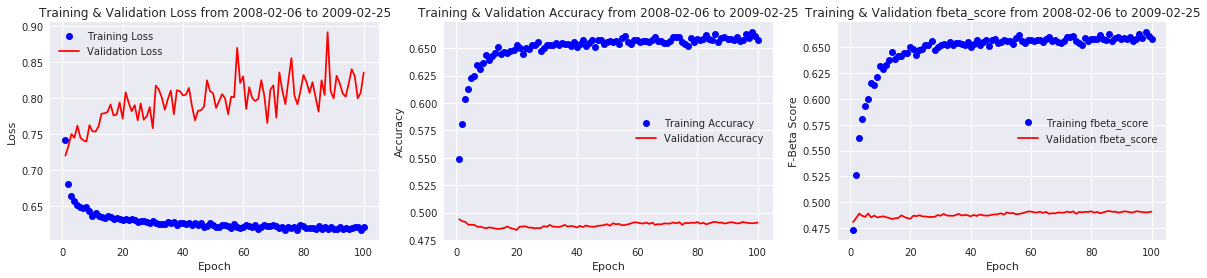

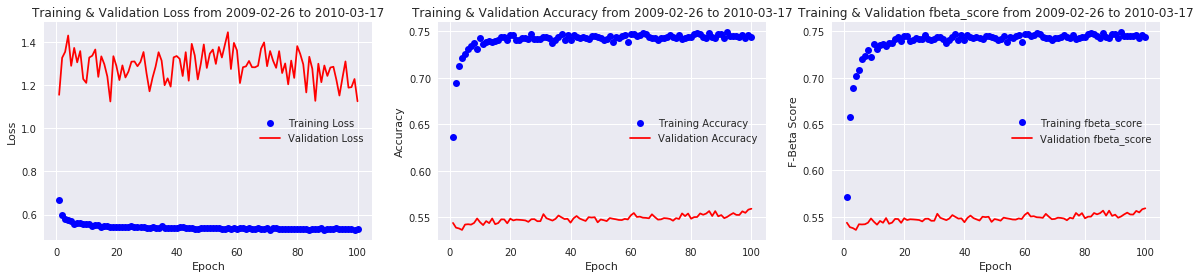

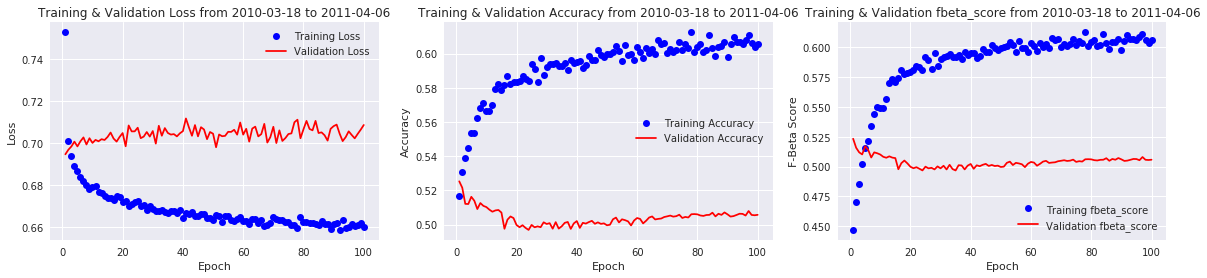

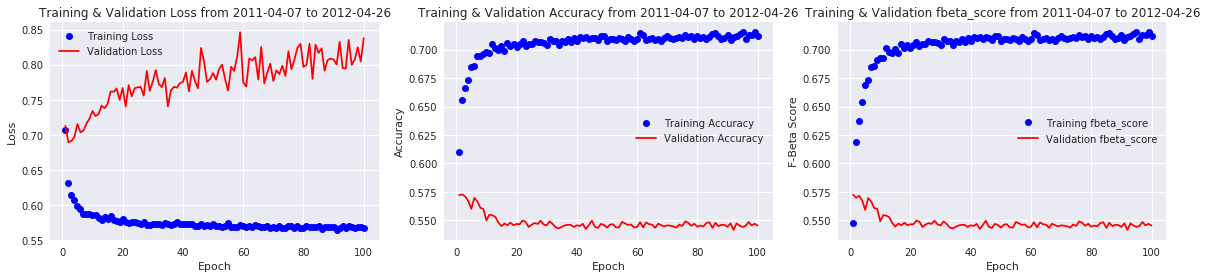

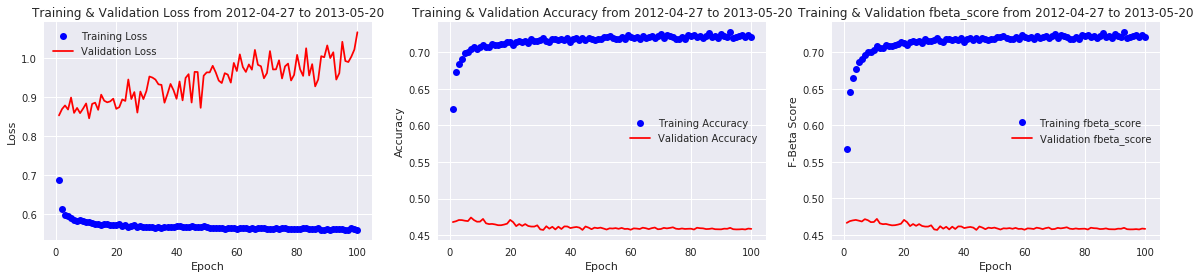

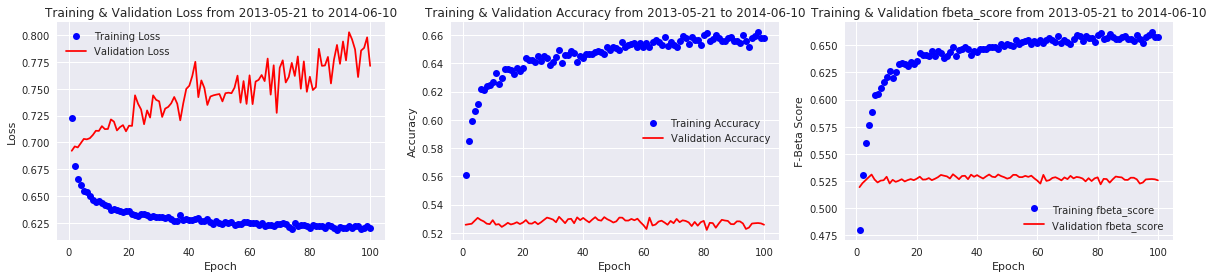

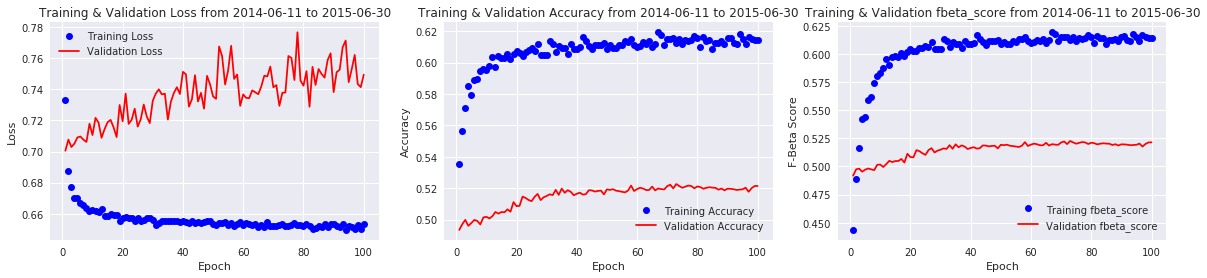

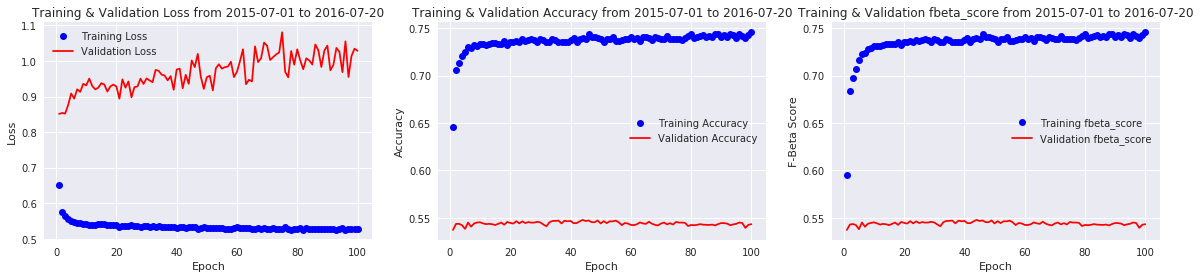

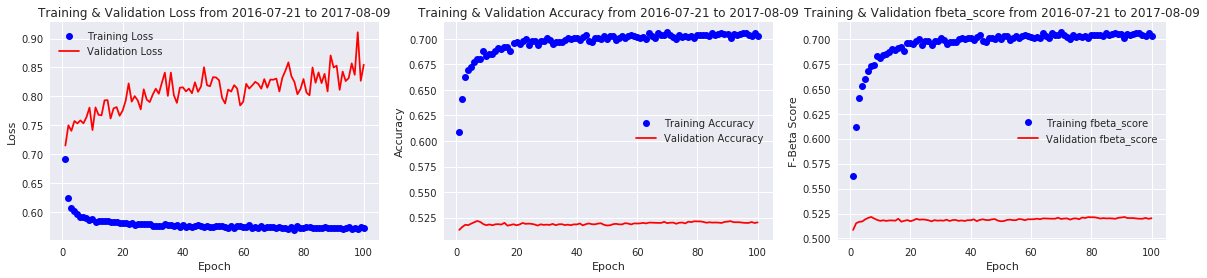

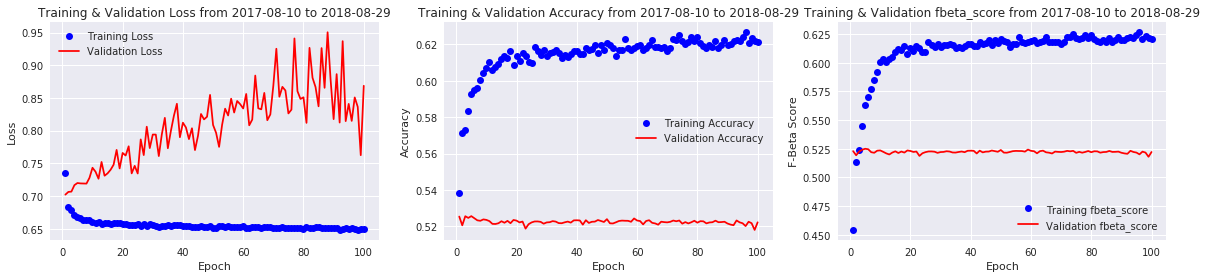

In [31]:
plotmetrics(df_model=ff_nn, oos_dates=ff_oos_dates)

## 5th Model: Long Short-Term Memory (LSTM) Neural Network 

The `lstm` user-defined function (UDF) was created to create a flexible architecture for this model. That UDF is referenced in the next cell which adjusts the data for a walk-forward cross-validation model that leverages `TimeSeriesSplit` from scikit-learn.

The final architecture being employed consists of the following parameters:

- 4 hidden layers with 50 units (neurons)
- Dropout probability: 40%
- Epochs: 100
- Batch size: 32
- Activation function: Sigmoid
- Loss function: Binary crossentropy 
- Optimizer: Adam

In [52]:
def lstm(x, y, validation_data, epochs, batch_size, num_layers, num_units, input_shape, dropout):
    
    model = Sequential()

    for _ in range(num_layers):
        model.add(LSTM(units=num_units, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
    
    model.add(Dense(2, 
                    activation='sigmoid'))

    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy', fbeta_score])
    
    ff_nn = model.fit(x=x, 
                      y=y,
                      epochs=epochs, 
                      validation_data=validation_data,
                      batch_size=batch_size, 
                      shuffle=False)
    
    predictions = model.predict_classes(validation_data[0])
    scores = model.evaluate(validation_data[0], validation_data[1])
    metric_names = model.metrics_names
        
    return ff_nn, predictions, scores, metric_names

In [53]:
#Testing keras
lstm_preds = []
lstm_symbols = []
lstm_oos_dates = []
lstm_scores = []
lstm_metric_names = [] 
lstm_nn = []
df = all_factors.dropna()
X = all_factors.dropna().unstack()[ml_features]
y = all_factors.dropna().unstack()[targets]
for train_index, test_index in tscv.split(df.unstack()[ml_features]):
    X_train, X_test, y_train, y_test = X.iloc[train_index].stack(),\
    X.iloc[test_index].stack(),\
    y.iloc[train_index].stack(),\
    y.iloc[test_index].stack()
    
    #Store symbols & dates here
    #--------------------------
    lstm_symbols.append(X_test.index.get_level_values(1))
    lstm_oos_dates.append(X_test.index.get_level_values(0))

    #Scale features
    #--------------
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Run neural network
    #------------------
    #convert targets to categorical
    y_train_categorical = to_categorical(y_train, num_classes=2) 
    y_test_categorical = to_categorical(y_test, num_classes=2)  
    
    #Reshape inputs
    #--------------
    X_train_lstm = np.reshape(X_train, 
                              (X_train.shape[0], 
                               1, 
                               X_train.shape[1]))
    X_test_lstm = np.reshape(X_test, 
                             (X_test.shape[0], 
                              1, 
                              X_test.shape[1]))
    y_train_lstm = np.reshape(y_train_categorical, 
                              (y_train_categorical.shape[0], 
                               1, 
                               y_train_categorical.shape[1]))
    y_test_lstm = np.reshape(y_test_categorical, 
                             (y_test_categorical.shape[0], 
                              1, 
                              y_test_categorical.shape[1]))
    
    #Store results
    #-------------
    results, predictions, scores, metric_names = lstm(
        x=X_train_lstm, 
        y=y_train_lstm, 
        validation_data=(X_test_lstm, y_test_lstm), 
        epochs=100,
        batch_size=32, 
        num_layers=4,
        num_units=50,
        input_shape=(1, X_train.shape[1]),
        dropout=.4
    )    
    
    #Save results
    #------------
    lstm_preds.append(predictions)
    lstm_nn.append(results)
    lstm_scores.append(scores)
    lstm_metric_names.append(metric_names)

Train on 8546 samples, validate on 108234 samples
Epoch 1/100
8546/8546 [==============================] - 29s 3ms/step - loss: 0.6749 - acc: 0.5817 - fbeta_score: 0.5817 - val_loss: 0.7492 - val_acc: 0.4982 - val_fbeta_score: 0.4982
Epoch 2/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.6429 - acc: 0.6252 - fbeta_score: 0.6252 - val_loss: 0.7738 - val_acc: 0.5013 - val_fbeta_score: 0.5013
Epoch 3/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.6325 - acc: 0.6360 - fbeta_score: 0.6360 - val_loss: 0.7860 - val_acc: 0.4987 - val_fbeta_score: 0.4987
Epoch 4/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.6290 - acc: 0.6406 - fbeta_score: 0.6406 - val_loss: 0.8081 - val_acc: 0.4966 - val_fbeta_score: 0.4966
Epoch 5/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.6246 - acc: 0.6457 - fbeta_score: 0.6457 - val_loss: 0.8088 - val_acc: 0.4914 - val_fbeta_score: 0.4914
Epoch 6/100
8546/8546 [=======

8546/8546 [==============================] - 26s 3ms/step - loss: 0.5066 - acc: 0.7443 - fbeta_score: 0.7443 - val_loss: 1.0447 - val_acc: 0.4881 - val_fbeta_score: 0.4881
Epoch 46/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.5081 - acc: 0.7526 - fbeta_score: 0.7526 - val_loss: 1.0506 - val_acc: 0.4897 - val_fbeta_score: 0.4897
Epoch 47/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.5018 - acc: 0.7526 - fbeta_score: 0.7526 - val_loss: 1.1103 - val_acc: 0.4913 - val_fbeta_score: 0.4913
Epoch 48/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.5062 - acc: 0.7439 - fbeta_score: 0.7439 - val_loss: 1.0708 - val_acc: 0.4922 - val_fbeta_score: 0.4922
Epoch 49/100
8546/8546 [==============================] - 26s 3ms/step - loss: 0.5023 - acc: 0.7487 - fbeta_score: 0.7487 - val_loss: 1.0331 - val_acc: 0.4925 - val_fbeta_score: 0.4925
Epoch 50/100
8546/8546 [==============================] - 25s 3ms/step - loss: 0.5023 - 

Epoch 33/100
8497/8497 [==============================] - 27s 3ms/step - loss: 0.4612 - acc: 0.7765 - fbeta_score: 0.7765 - val_loss: 1.1378 - val_acc: 0.5580 - val_fbeta_score: 0.5580
Epoch 34/100
8497/8497 [==============================] - 27s 3ms/step - loss: 0.4638 - acc: 0.7751 - fbeta_score: 0.7751 - val_loss: 1.1263 - val_acc: 0.5570 - val_fbeta_score: 0.5570
Epoch 35/100
8497/8497 [==============================] - 26s 3ms/step - loss: 0.4602 - acc: 0.7756 - fbeta_score: 0.7756 - val_loss: 1.1114 - val_acc: 0.5549 - val_fbeta_score: 0.5549
Epoch 36/100
8497/8497 [==============================] - 26s 3ms/step - loss: 0.4590 - acc: 0.7760 - fbeta_score: 0.7760 - val_loss: 1.0717 - val_acc: 0.5557 - val_fbeta_score: 0.5557
Epoch 37/100
8497/8497 [==============================] - 27s 3ms/step - loss: 0.4543 - acc: 0.7802 - fbeta_score: 0.7802 - val_loss: 1.1688 - val_acc: 0.5586 - val_fbeta_score: 0.5586
Epoch 38/100
8497/8497 [==============================] - 26s 3ms/step - lo

Epoch 21/100
9786/9786 [==============================] - 30s 3ms/step - loss: 0.6096 - acc: 0.6511 - fbeta_score: 0.6511 - val_loss: 0.8244 - val_acc: 0.5266 - val_fbeta_score: 0.5266
Epoch 22/100
9786/9786 [==============================] - 29s 3ms/step - loss: 0.6088 - acc: 0.6573 - fbeta_score: 0.6573 - val_loss: 0.8442 - val_acc: 0.5245 - val_fbeta_score: 0.5245
Epoch 23/100
9786/9786 [==============================] - 29s 3ms/step - loss: 0.6034 - acc: 0.6532 - fbeta_score: 0.6532 - val_loss: 0.8357 - val_acc: 0.5239 - val_fbeta_score: 0.5239
Epoch 24/100
9786/9786 [==============================] - 30s 3ms/step - loss: 0.6025 - acc: 0.6581 - fbeta_score: 0.6581 - val_loss: 0.8540 - val_acc: 0.5260 - val_fbeta_score: 0.5260
Epoch 25/100
9786/9786 [==============================] - 29s 3ms/step - loss: 0.6008 - acc: 0.6639 - fbeta_score: 0.6639 - val_loss: 0.8575 - val_acc: 0.5253 - val_fbeta_score: 0.5253
Epoch 26/100
9786/9786 [==============================] - 29s 3ms/step - lo

Epoch 9/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.5624 - acc: 0.7078 - fbeta_score: 0.7078 - val_loss: 0.7547 - val_acc: 0.5348 - val_fbeta_score: 0.5348
Epoch 10/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.5578 - acc: 0.7121 - fbeta_score: 0.7121 - val_loss: 0.7559 - val_acc: 0.5376 - val_fbeta_score: 0.5376
Epoch 11/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.5549 - acc: 0.7154 - fbeta_score: 0.7154 - val_loss: 0.7667 - val_acc: 0.5372 - val_fbeta_score: 0.5372
Epoch 12/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.5528 - acc: 0.7116 - fbeta_score: 0.7116 - val_loss: 0.7766 - val_acc: 0.5323 - val_fbeta_score: 0.5323
Epoch 13/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.5517 - acc: 0.7188 - fbeta_score: 0.7188 - val_loss: 0.7830 - val_acc: 0.5308 - val_fbeta_score: 0.5308
Epoch 14/100
10267/10267 [==============================] - 30s 3m

Epoch 53/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.4567 - acc: 0.7881 - fbeta_score: 0.7881 - val_loss: 1.1089 - val_acc: 0.5276 - val_fbeta_score: 0.5276
Epoch 54/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.4577 - acc: 0.7911 - fbeta_score: 0.7911 - val_loss: 1.1503 - val_acc: 0.5267 - val_fbeta_score: 0.5267
Epoch 55/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.4538 - acc: 0.7868 - fbeta_score: 0.7868 - val_loss: 1.1161 - val_acc: 0.5291 - val_fbeta_score: 0.5291
Epoch 56/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.4557 - acc: 0.7851 - fbeta_score: 0.7851 - val_loss: 1.1173 - val_acc: 0.5262 - val_fbeta_score: 0.5262
Epoch 57/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.4495 - acc: 0.7879 - fbeta_score: 0.7879 - val_loss: 1.1645 - val_acc: 0.5260 - val_fbeta_score: 0.5260
Epoch 58/100
10267/10267 [==============================] - 30s 3

Epoch 97/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.3837 - acc: 0.8264 - fbeta_score: 0.8264 - val_loss: 1.2281 - val_acc: 0.5287 - val_fbeta_score: 0.5287
Epoch 98/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.3846 - acc: 0.8255 - fbeta_score: 0.8255 - val_loss: 1.2766 - val_acc: 0.5312 - val_fbeta_score: 0.5312
Epoch 99/100
10267/10267 [==============================] - 30s 3ms/step - loss: 0.3809 - acc: 0.8288 - fbeta_score: 0.8288 - val_loss: 1.3114 - val_acc: 0.5288 - val_fbeta_score: 0.5288
Epoch 100/100
128048/128048 [==============================] - 25s 197us/step
Train on 10393 samples, validate on 134287 samples
Epoch 1/100
10393/10393 [==============================] - 37s 4ms/step - loss: 0.6224 - acc: 0.6469 - fbeta_score: 0.6469 - val_loss: 0.8637 - val_acc: 0.4679 - val_fbeta_score: 0.4679
Epoch 2/100
10393/10393 [==============================] - 31s 3ms/step - loss: 0.5806 - acc: 0.7005 - fbeta_score: 0.7005 -

Epoch 84/100
10393/10393 [==============================] - 31s 3ms/step - loss: 0.3925 - acc: 0.8180 - fbeta_score: 0.8180 - val_loss: 1.3268 - val_acc: 0.4881 - val_fbeta_score: 0.4881
Epoch 85/100
10393/10393 [==============================] - 32s 3ms/step - loss: 0.3880 - acc: 0.8227 - fbeta_score: 0.8227 - val_loss: 1.3303 - val_acc: 0.4865 - val_fbeta_score: 0.4865
Epoch 86/100
10393/10393 [==============================] - 32s 3ms/step - loss: 0.3844 - acc: 0.8245 - fbeta_score: 0.8245 - val_loss: 1.3333 - val_acc: 0.4877 - val_fbeta_score: 0.4877
Epoch 87/100
10393/10393 [==============================] - 32s 3ms/step - loss: 0.3828 - acc: 0.8270 - fbeta_score: 0.8270 - val_loss: 1.3561 - val_acc: 0.4826 - val_fbeta_score: 0.4826
Epoch 88/100
10393/10393 [==============================] - 31s 3ms/step - loss: 0.3818 - acc: 0.8274 - fbeta_score: 0.8274 - val_loss: 1.3911 - val_acc: 0.4865 - val_fbeta_score: 0.4865
Epoch 89/100
10393/10393 [==============================] - 31s 3

Epoch 71/100
10864/10864 [==============================] - 33s 3ms/step - loss: 0.4435 - acc: 0.7864 - fbeta_score: 0.7864 - val_loss: 1.0826 - val_acc: 0.5209 - val_fbeta_score: 0.5209
Epoch 72/100
10864/10864 [==============================] - 33s 3ms/step - loss: 0.4425 - acc: 0.7827 - fbeta_score: 0.7827 - val_loss: 1.0763 - val_acc: 0.5207 - val_fbeta_score: 0.5207
Epoch 73/100
10864/10864 [==============================] - 33s 3ms/step - loss: 0.4411 - acc: 0.7852 - fbeta_score: 0.7852 - val_loss: 1.0815 - val_acc: 0.5198 - val_fbeta_score: 0.5198
Epoch 74/100
10864/10864 [==============================] - 33s 3ms/step - loss: 0.4363 - acc: 0.7893 - fbeta_score: 0.7893 - val_loss: 1.0762 - val_acc: 0.5199 - val_fbeta_score: 0.5199
Epoch 75/100
10864/10864 [==============================] - 33s 3ms/step - loss: 0.4395 - acc: 0.7884 - fbeta_score: 0.7884 - val_loss: 1.0711 - val_acc: 0.5200 - val_fbeta_score: 0.5200
Epoch 76/100
10864/10864 [==============================] - 33s 3

Epoch 58/100
11291/11291 [==============================] - 34s 3ms/step - loss: 0.5098 - acc: 0.7399 - fbeta_score: 0.7399 - val_loss: 1.1588 - val_acc: 0.5203 - val_fbeta_score: 0.5203
Epoch 59/100
11291/11291 [==============================] - 34s 3ms/step - loss: 0.5084 - acc: 0.7411 - fbeta_score: 0.7411 - val_loss: 1.1290 - val_acc: 0.5178 - val_fbeta_score: 0.5178
Epoch 60/100
11291/11291 [==============================] - 34s 3ms/step - loss: 0.5001 - acc: 0.7457 - fbeta_score: 0.7457 - val_loss: 1.1816 - val_acc: 0.5203 - val_fbeta_score: 0.5203
Epoch 61/100
11291/11291 [==============================] - 34s 3ms/step - loss: 0.4982 - acc: 0.7477 - fbeta_score: 0.7477 - val_loss: 1.2023 - val_acc: 0.5192 - val_fbeta_score: 0.5192
Epoch 62/100
11291/11291 [==============================] - 33s 3ms/step - loss: 0.4967 - acc: 0.7480 - fbeta_score: 0.7480 - val_loss: 1.2043 - val_acc: 0.5181 - val_fbeta_score: 0.5181
Epoch 63/100
11291/11291 [==============================] - 34s 3

Epoch 45/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3895 - acc: 0.8173 - fbeta_score: 0.8173 - val_loss: 1.1969 - val_acc: 0.5393 - val_fbeta_score: 0.5393
Epoch 46/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3895 - acc: 0.8166 - fbeta_score: 0.8166 - val_loss: 1.1578 - val_acc: 0.5365 - val_fbeta_score: 0.5365
Epoch 47/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3831 - acc: 0.8180 - fbeta_score: 0.8180 - val_loss: 1.1764 - val_acc: 0.5385 - val_fbeta_score: 0.5385
Epoch 48/100
11507/11507 [==============================] - 36s 3ms/step - loss: 0.3849 - acc: 0.8184 - fbeta_score: 0.8184 - val_loss: 1.1710 - val_acc: 0.5390 - val_fbeta_score: 0.5390
Epoch 49/100
11507/11507 [==============================] - 36s 3ms/step - loss: 0.3818 - acc: 0.8183 - fbeta_score: 0.8183 - val_loss: 1.1813 - val_acc: 0.5398 - val_fbeta_score: 0.5398
Epoch 50/100
11507/11507 [==============================] - 35s 3

Epoch 89/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3191 - acc: 0.8615 - fbeta_score: 0.8615 - val_loss: 1.3533 - val_acc: 0.5433 - val_fbeta_score: 0.5433
Epoch 90/100
11507/11507 [==============================] - 36s 3ms/step - loss: 0.3142 - acc: 0.8663 - fbeta_score: 0.8663 - val_loss: 1.3971 - val_acc: 0.5414 - val_fbeta_score: 0.5414
Epoch 91/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3164 - acc: 0.8622 - fbeta_score: 0.8622 - val_loss: 1.3559 - val_acc: 0.5442 - val_fbeta_score: 0.5442
Epoch 92/100
11507/11507 [==============================] - 36s 3ms/step - loss: 0.3121 - acc: 0.8690 - fbeta_score: 0.8690 - val_loss: 1.3242 - val_acc: 0.5430 - val_fbeta_score: 0.5430
Epoch 93/100
11507/11507 [==============================] - 35s 3ms/step - loss: 0.3048 - acc: 0.8686 - fbeta_score: 0.8686 - val_loss: 1.3860 - val_acc: 0.5433 - val_fbeta_score: 0.5433
Epoch 94/100
11507/11507 [==============================] - 35s 3

Epoch 76/100
12251/12251 [==============================] - 38s 3ms/step - loss: 0.3980 - acc: 0.8164 - fbeta_score: 0.8164 - val_loss: 1.3532 - val_acc: 0.5201 - val_fbeta_score: 0.5201
Epoch 77/100
12251/12251 [==============================] - 38s 3ms/step - loss: 0.3986 - acc: 0.8183 - fbeta_score: 0.8183 - val_loss: 1.3099 - val_acc: 0.5202 - val_fbeta_score: 0.5202
Epoch 78/100
12251/12251 [==============================] - 38s 3ms/step - loss: 0.3979 - acc: 0.8191 - fbeta_score: 0.8191 - val_loss: 1.2959 - val_acc: 0.5155 - val_fbeta_score: 0.5155
Epoch 79/100
12251/12251 [==============================] - 38s 3ms/step - loss: 0.3942 - acc: 0.8214 - fbeta_score: 0.8214 - val_loss: 1.3166 - val_acc: 0.5198 - val_fbeta_score: 0.5198
Epoch 80/100
12251/12251 [==============================] - 38s 3ms/step - loss: 0.3953 - acc: 0.8163 - fbeta_score: 0.8163 - val_loss: 1.3077 - val_acc: 0.5198 - val_fbeta_score: 0.5198
Epoch 81/100
12251/12251 [==============================] - 38s 3

Epoch 63/100
13021/13021 [==============================] - 40s 3ms/step - loss: 0.4632 - acc: 0.7807 - fbeta_score: 0.7807 - val_loss: 1.0128 - val_acc: 0.5276 - val_fbeta_score: 0.5276
Epoch 64/100
13021/13021 [==============================] - 39s 3ms/step - loss: 0.4617 - acc: 0.7795 - fbeta_score: 0.7795 - val_loss: 0.9963 - val_acc: 0.5239 - val_fbeta_score: 0.5239
Epoch 65/100
13021/13021 [==============================] - 40s 3ms/step - loss: 0.4578 - acc: 0.7837 - fbeta_score: 0.7837 - val_loss: 1.0432 - val_acc: 0.5272 - val_fbeta_score: 0.5272
Epoch 66/100
13021/13021 [==============================] - 39s 3ms/step - loss: 0.4583 - acc: 0.7825 - fbeta_score: 0.7825 - val_loss: 1.0393 - val_acc: 0.5269 - val_fbeta_score: 0.5269
Epoch 67/100
13021/13021 [==============================] - 41s 3ms/step - loss: 0.4570 - acc: 0.7863 - fbeta_score: 0.7863 - val_loss: 1.0237 - val_acc: 0.5254 - val_fbeta_score: 0.5254
Epoch 68/100
13021/13021 [==============================] - 39s 3

In [92]:
#Reshape array
reshaped_lstm_preds = np.squeeze(np.reshape(np.concatenate(lstm_preds), 
                                            (1, 
                                             len(np.concatenate(lstm_preds)))))

lstm_predsdf = pd.DataFrame(
    {'pred': reshaped_lstm_preds
    }, 
    index=[np.concatenate(lstm_oos_dates),
           np.concatenate(lstm_symbols)]
)

lstm_predsdf.index.names = ['date', 'ticker']

lstm_data = pd.merge(
    lstm_predsdf,
    all_factors[['fwdret_63d']],
    how='left',
    left_index=True,
    right_index=True
)

lstm_data.to_csv('lstm_preds.csv')

In [95]:
lstm_metrics = pd.DataFrame(lstm_scores, columns=lstm_metric_names[0])
lstm_metrics.to_csv('lstm_metrics.csv')

In [96]:
lstm_metrics

loss       acc  fbeta_score
0  1.369334  0.499464     0.499464
1  1.156364  0.552118     0.552118
2  1.216872  0.531661     0.531661
3  1.271695  0.530606     0.530606
4  1.415816  0.487918     0.487918
5  1.178006  0.523391     0.523391
6  1.414063  0.526535     0.526535
7  1.408048  0.542812     0.542812
8  1.376371  0.519093     0.519093
9  1.128356  0.529583     0.529583

Similar to before, I'd like to focus our attention on the F1 scores. The biggest departure from the feed forward model we ran earlier can be seen by looking at how well the LSTM model learns the data in the training set. We see large and steady improvements for each of the epochs across the 10-year study. Unfortunately, and as we've seen with each model up to this point, those large gains in predictive ability do not carry over to the validation set.

This model shows a lot of promise and there is a lot of room for improvement however those adjustments must be weighed against the computational expense that will be introduced. Given the promising results generated by the random forest model, and the lower computing requirements, I'm favoring that model over reworking the LSTM model any further.

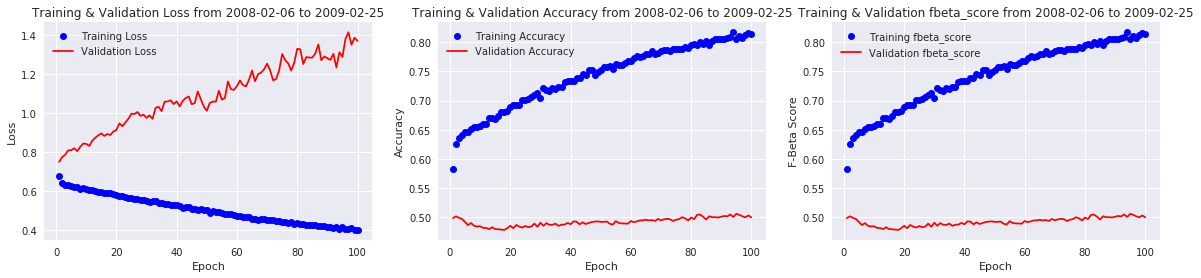

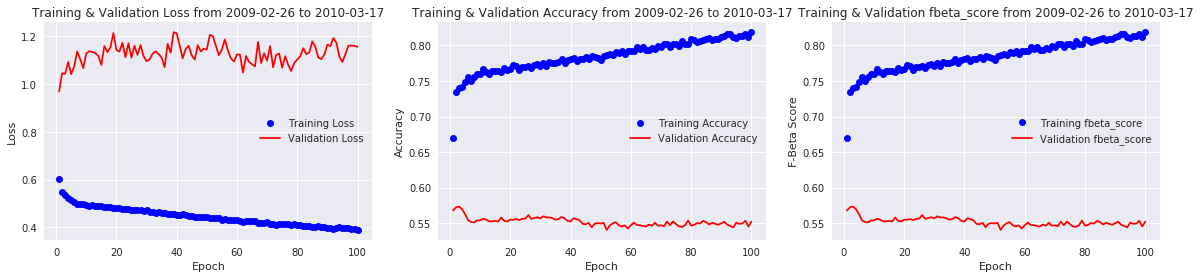

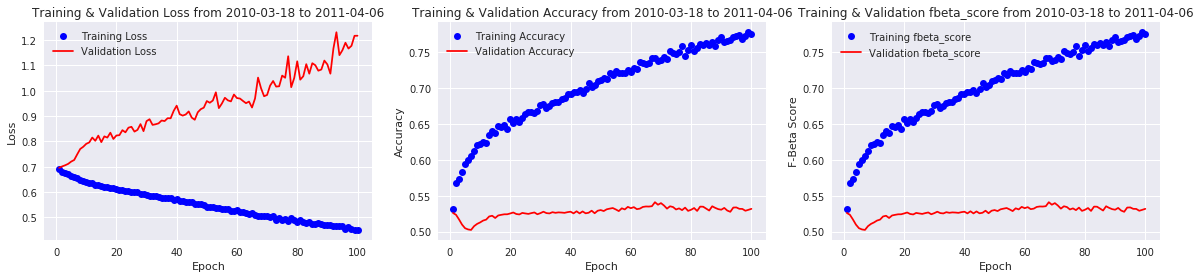

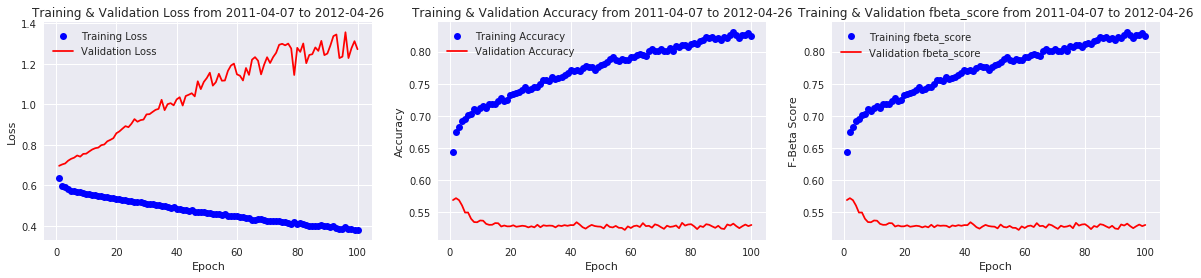

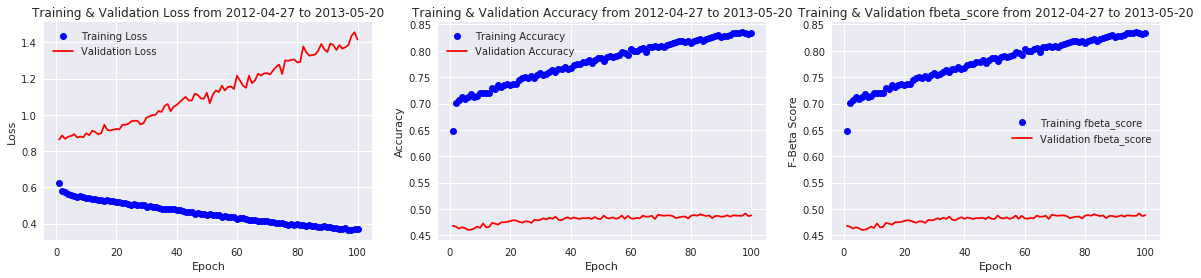

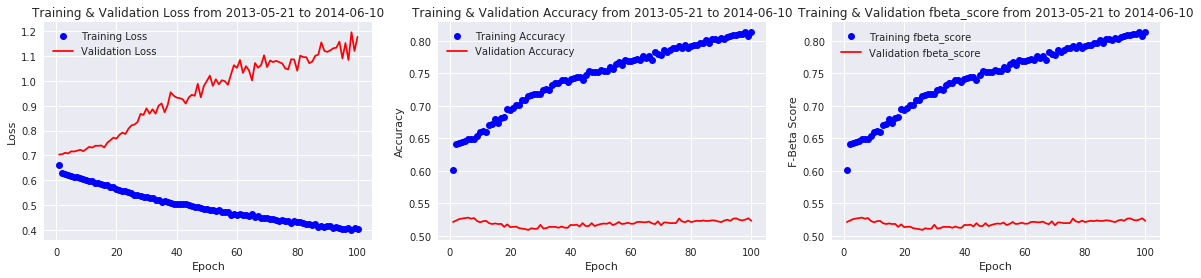

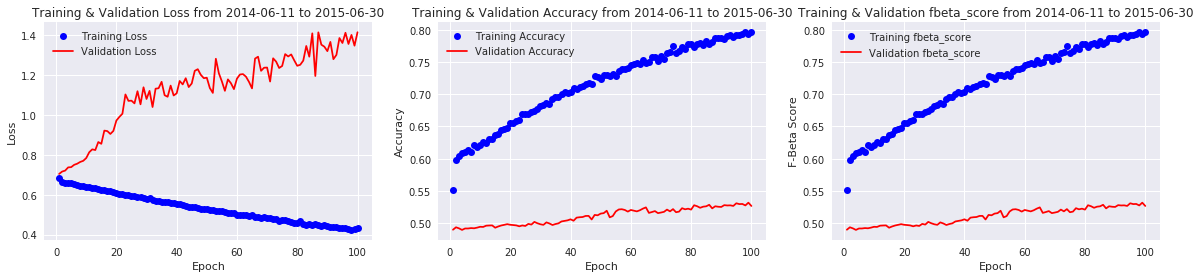

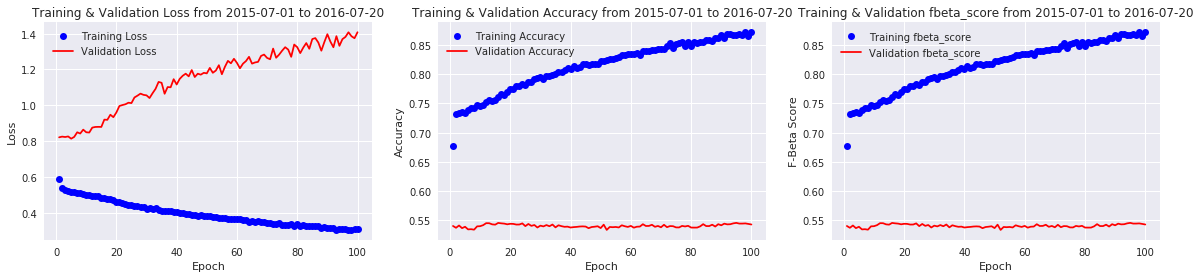

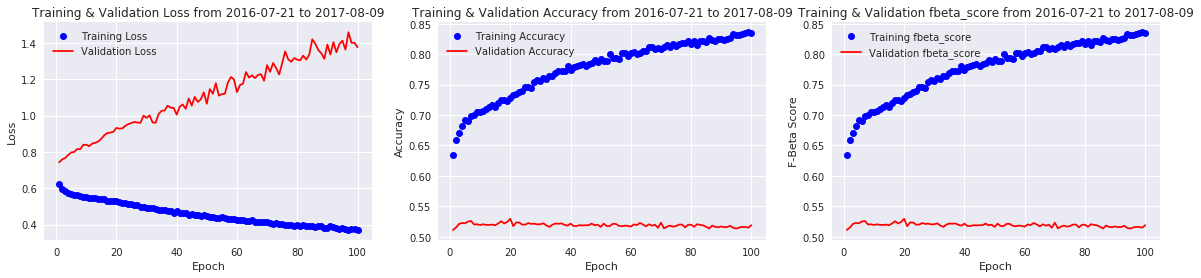

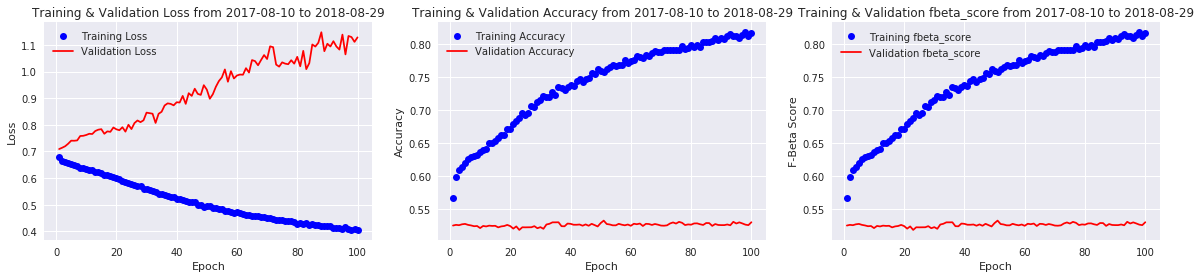

In [94]:
plotmetrics(df_model=lstm_nn, oos_dates=lstm_oos_dates)